<a href="https://colab.research.google.com/github/mkunyosi/FLAI-ML-DDS8/blob/learning/DDS8_CompML_Pycaret_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FLAI - 8ª Competição de Machine Learning


> *Sorte é o que acontece quando a preparação encontra a oportunidade - Elmer Letterman*


Este notebook teve como inspiração a *live* com os vencedores da 7ª competição de machine learning da FLAI. Naquela competição tive algumas dificuldades para tratar as variáveis e tive um resultado "ruim", ficando fora dos *top 10*. Aproveitei aquele momento para aprender com os demais colegas e fiz uma lista de aprendizados os quais me guiaram na 8ª competição.

**Aprendizados da *live* com os vencerdores da 7ª competição de ML**

- Os melhores ganhos em métrica acontecem escolhendo bem as variáveis de entrada e fazendo transformações apropriadas
- Para saber qual variável deve, ou não, ser usada é preciso fazer testes
- Para saber qual transformação é boa é preciso fazer testes
- Há muitas combinações possíveis, então é preciso testar tudo, guardar os dados e analisar posteriormente
- Tunar modelo ajuda, porém, pelo menos na 7ª competição, não tive a impressão que contribuísse tanto para fazer diferença no resultado final
- Para ficar entre os top 5, é necessário executar os passos anteriores e ter sorte para obter uma combinação das variáveis, transformações e modelos que gerem as melhores métricas

**Abordagem usada na competição**
- Utilizar o Pycaret como ferramenta de ML
- Testar diversas configurações:
 - Diferentes dataset
 - Diferentes tranformações de dados
- Utilizar o Pycaret fazer o tuning e ensemble dos modelos

**Conclusões**

Após investir várias horas na construção deste notebook, quase sempre madrugadas a dentro, já estava bastante incomodado com os "baixos" resultados obtidos na competição. Afinal tanto esforço não estava resultando em um "bom" score. Foi, então, que o último item da minha lista de aprendizado deu o ar da graça, ou seja, o fator **sorte** apareceu e com ele consegui gerar uma submissão a qual me rendeu a 2ª posição no ranking final da competição.

A sorte passou rápida, pensei que tivesse salvo tudo naquele momento, porém não consegui melhorar o modelo nem reproduzir todos os passos novamente. Mesmo salvando todas as etapas e guardando as sementes, supostamente necessárias, para reproduzir o mesmo modelo em circunstâncias futuras, não foi possível reproduzir o modelo fielmente.

Apesar de não conseguir gerar um mesmo modelo bem sucedido reproduzindo os passos de construção do modelo, naquele momento de sorte consegui salvar o modelo finalizado, então para aqueles que desejarem será possível gerar uma submissão idêntica a que eu gerei.

Por que não consegui gerar o mesmo modelo?

O passo que apresenta a "falha" é o e criar um ensemble com alguns modelos. Ao rodar esse passo as saídas geradas "sempre" são diferentes. É como se um "gerador aleatório" fosse ativado a cada execução, então os resultados não saem iguais aos anteriores. Por sorte, quando gerei o modelo a combinação naquele momento proporcionou meu "melhor" modelo.

Os mais atentos devem ter notado que nos parágrafos anteriores usei aspas ao comentar sobre "bons modelos" e "baixos resultados". As aspas são porque, analisando os resultados finais dessa competição, qualquer colega que tenha gerado um modelo com score acima de 0,7900 esteve bem próximo de um modelo que poderia gerar um score de 0,8000. Faltou um detalhe ou pouco mais de sorte para chegar num modelo melhor. Dessa forma, excluindo o cenário da competição, não é possível afirmar que um modelo seja ruim porque obteve, por exemplo, 0,7900. Se você leitor está nessa situação, sinta-se orgulhoso do seu trabalho e continue perseverando que uma hora a sorte vai aparecer para você também! 

O que apresento, então, neste notebook são os passos que eu executei para obter o modelo que gerou minha 9ª submissão, aquela que obteve minha melhor pontuação (0,80120), sendo a 2ª melhor no *ranking* geral. Entre as células de códigos também há comentários pertinentes.

Todo como premissa que este notebook está sendo executado no ambiente do Google Colab.

**Marcos Kunyosi** (abril/2022)


# **Initial setup**

### Installs and imports

No Colab, ao rodar a instalação do PyCaret pela primeira vez, sempre ocorre um erro (mar/2022). Para contornar essa situação, eu reinicio o ambiente do Colab e rodo novamente a instalação.

In [1]:
!pip install pycaret

In [2]:
!pip install sweetviz 
import sweetviz as sv

In [3]:
# importing google drive (not used here)
if False:    
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
# importando o pandas
import pandas as pd 

In [5]:
# import lightgbm as lgb
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import Pipeline

In [6]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# from sklearn.model_selection import cross_validate
# from sklearn.model_selection import RepeatedStratifiedKFold
# from sklearn.model_selection import cross_val_score

from sklearn.metrics import f1_score

from IPython.display import clear_output

In [7]:
from pycaret.classification import *

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


### General Functions

In [8]:
def df_export_file(df, fname, typeOfFile='excel'):
    subm = df    
    if typeOfFile == 'excel':
        df.to_excel(fname, sheet_name="results")
    elif typeOfFile == 'csv':
        #subm.to_csv('subm_02_test.csv', index = False)
        df.to_csv(fname, index = False)
    elif typeOfFile == 'pkl':
        # do nothing
        pass
    else:
        print(f'df_export_file-error: invalid "typeOfFile" ({typeOfFile})')
        return
    
    from google.colab import files
    files.download(fname)

# samples
if False:
    # downloading a pkl file (stored on Colab)
    df_export_file([], 'Final_Model.pkl', typeOfFile='pkl')

    # downloading a xlsx file (stored on Colab)
    df_export_file(pred, "ExcelFile.xlsx")    

    # downloading a csv file (stored on Colab)
    df_export_file(sub, 'sub.csv', typeOfFile='csv')        

In [9]:
def dataset_refresh():
    df_train = original_train.copy()
    df_test = original_test.copy()
    return df_train, df_test

## **Loading dataset**

In [10]:
# path to dataset files (train and test)
train_url = 'https://raw.githubusercontent.com/mkunyosi/FLAI-ML-DDS8/learning/treino.csv'
test_url = 'https://raw.githubusercontent.com/mkunyosi/FLAI-ML-DDS8/learning/teste.csv'


# importing dataset to "reusable variables"
original_train = pd.read_csv(train_url, sep = ';', decimal = ',')
original_test = pd.read_csv(test_url, sep = ';', decimal = ',')


In [11]:
# df_train and df_test contain data to be on experiments
# For fresh instances of datasets use code below:
df_train, df_test = dataset_refresh()

## Checking the datasets

In [12]:
df_train.tail(3)

,func_sexo,func_idade,func_racacor,func_escolaridade,func_uf,func_deficiencia,empresa_porte,empresa_setor,contrato_horastrabalho,contrato_salario,turnover_apos_1_ano
14997,MASCULINO,24,PRETA-PARDA,MEDIO COMPLETO,CE,NAO,DE 20 A 49,Indústria,44,1029.98,NAO
14998,FEMININO,40,PRETA-PARDA,MEDIO COMPLETO,BA,NAO,1000 OU MAIS,Serviços,30,1923.33,SIM
14999,FEMININO,25,SEM INFO,MEDIO COMPLETO,PE,NAO,DE 100 A 249,Serviços,36,1003.80,NAO


In [13]:
df_train.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   func_sexo               15000 non-null  object 
 1   func_idade              15000 non-null  int64  
 2   func_racacor            15000 non-null  object 
 3   func_escolaridade       15000 non-null  object 
 4   func_uf                 15000 non-null  object 
 5   func_deficiencia        15000 non-null  object 
 6   empresa_porte           15000 non-null  object 
 7   empresa_setor           15000 non-null  object 
 8   contrato_horastrabalho  15000 non-null  int64  
 9   contrato_salario        15000 non-null  float64
 10  turnover_apos_1_ano     15000 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 1.3+ MB


In [14]:
df_test.head(3)

,func_sexo,func_idade,func_racacor,func_escolaridade,func_uf,func_deficiencia,empresa_porte,empresa_setor,contrato_horastrabalho,contrato_salario
0,FEMININO,30,PRETA-PARDA,MEDIO COMPLETO,MA,NAO,ATE 4,Comércio,44,1583.19
1,MASCULINO,21,SEM INFO,MEDIO COMPLETO,BA,NAO,DE 5 A 9,Indústria,44,979.95
2,FEMININO,26,SEM INFO,MEDIO COMPLETO,RN,NAO,ATE 4,Comércio,44,1015.85


In [15]:
df_test.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   func_sexo               15000 non-null  object 
 1   func_idade              15000 non-null  int64  
 2   func_racacor            15000 non-null  object 
 3   func_escolaridade       15000 non-null  object 
 4   func_uf                 15000 non-null  object 
 5   func_deficiencia        15000 non-null  object 
 6   empresa_porte           15000 non-null  object 
 7   empresa_setor           15000 non-null  object 
 8   contrato_horastrabalho  15000 non-null  int64  
 9   contrato_salario        15000 non-null  float64
dtypes: float64(1), int64(2), object(7)
memory usage: 1.1+ MB


# **EDA**

Não fiz uma análise rigorosa dos dados. Utilizei o SweetViz e funções padrões para analisar as variáveis.

Procurei dar foco na identificação de possíveis transformações nos dados a serem testadas em passos futuros.

**Principais *insights*:**

- Tratar algumas variávies em vez de todas juntas
- Variáveis categóricas: 
  - Fazer *dummificação*
  - Fazer ordenação em "empresa_porte" e "func_escolaridade"
- Analisar *target* com NAO e SIM como 1 e 0, respectivamente.
- Normalizar variáveis numéricas via Pycaret (aplicação de log)
- Tratar outliers nas variáveis numéricas
  - Fazer ajustes manuais (não deixei via Pycaret) em "contrato_salario" e "func_idade"
- Fazer balanceamento de dados (mesma distribuição de SIM e NAO)
  - Tentar métodos under sample e over sample


## Using SweetViz

                                             |          | [  0%]   00:00 -> (? left)


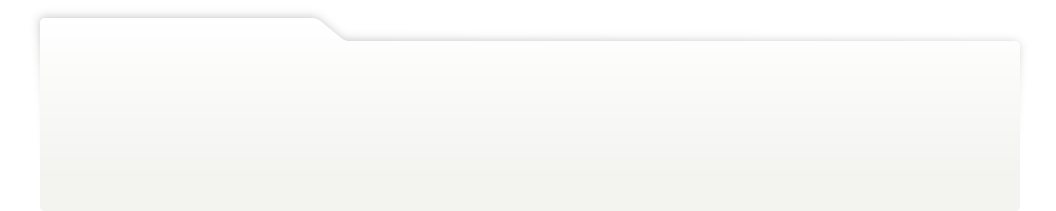
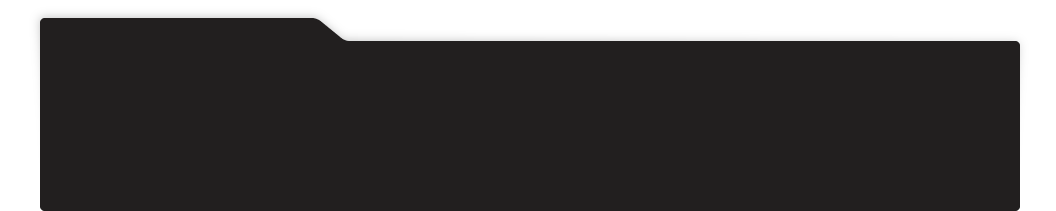
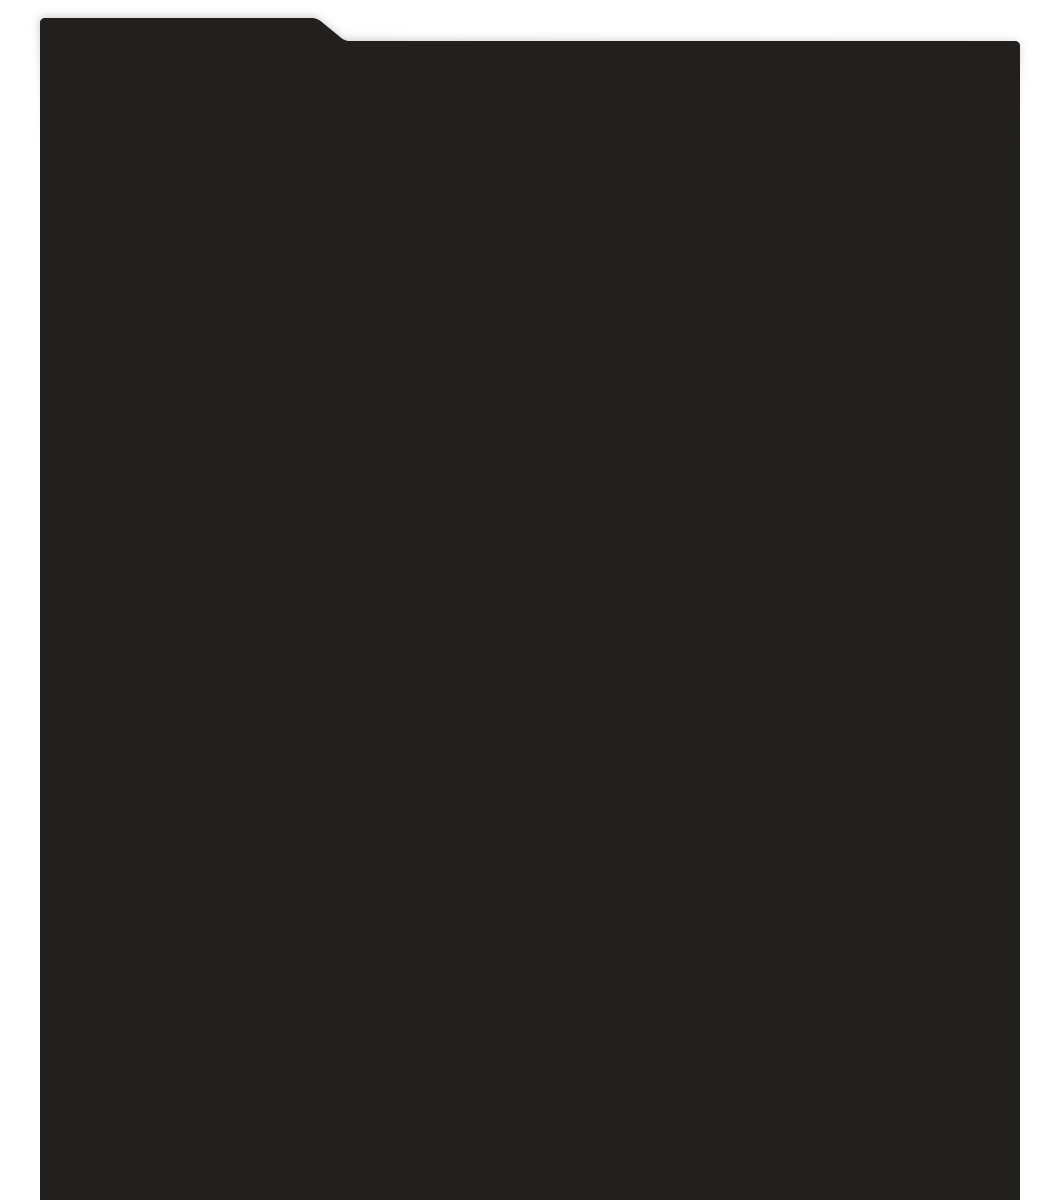
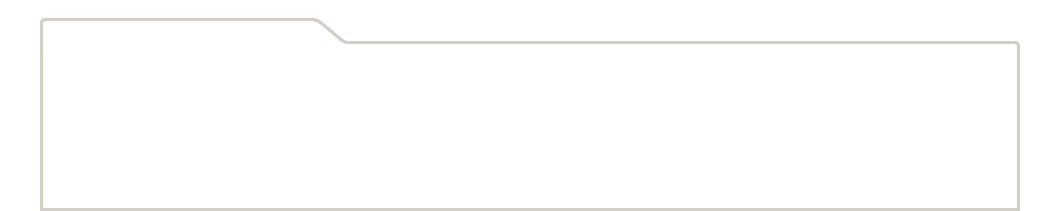
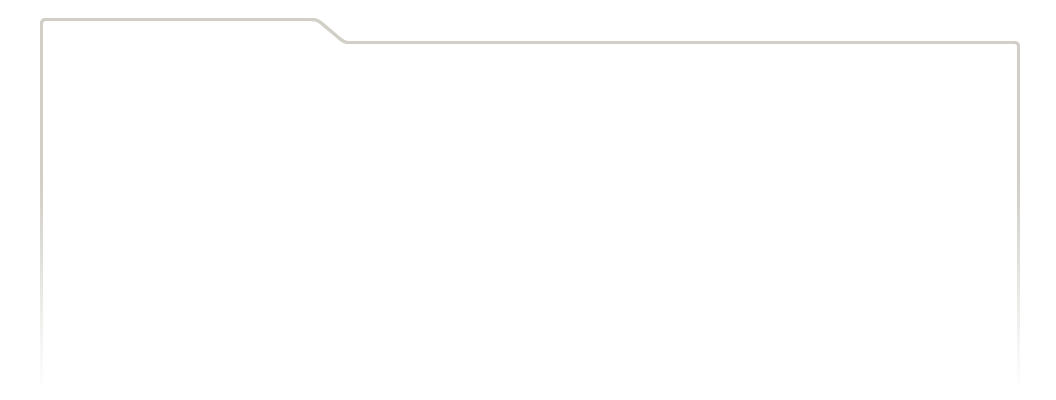
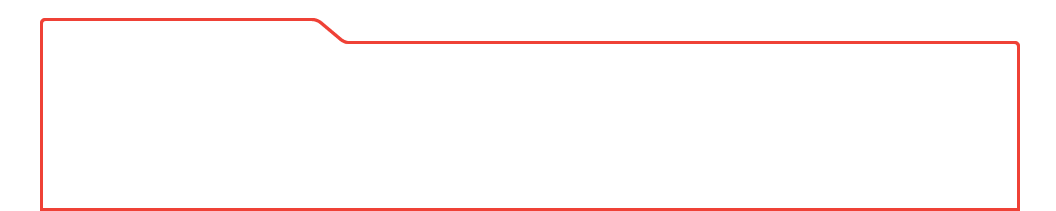
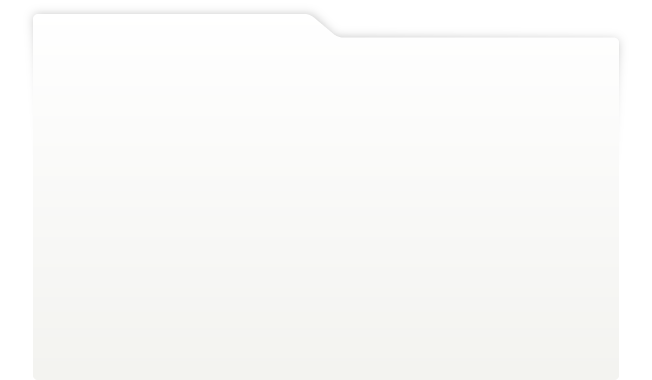
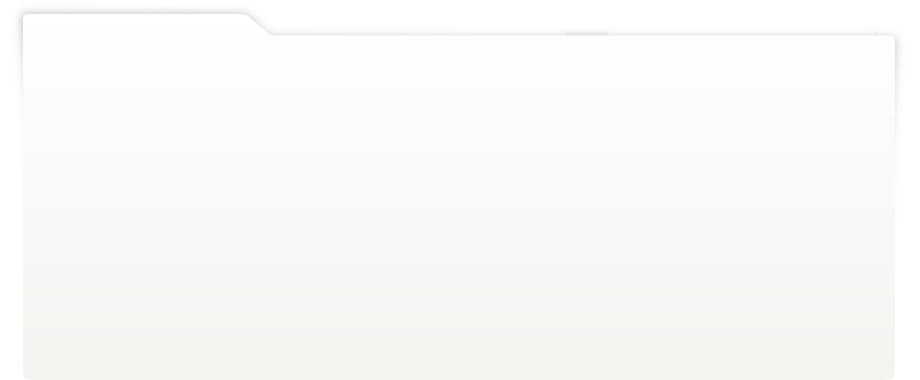
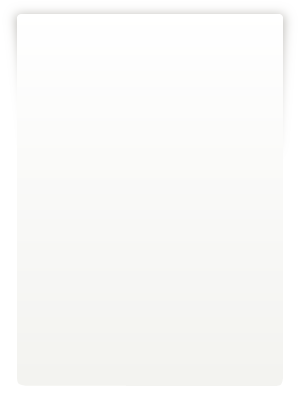
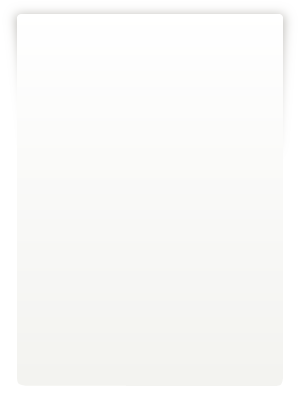
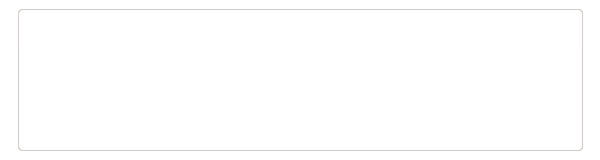
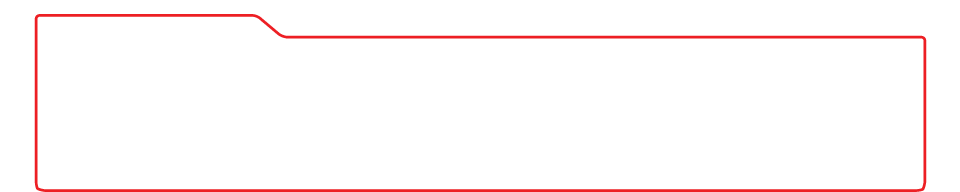
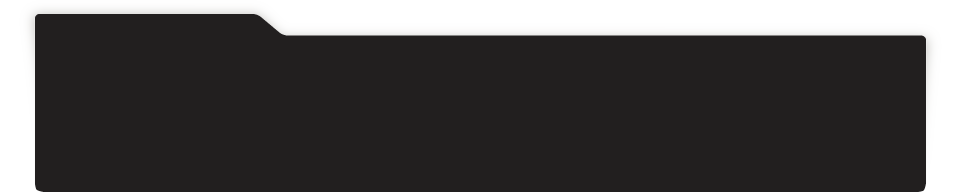
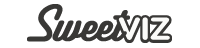
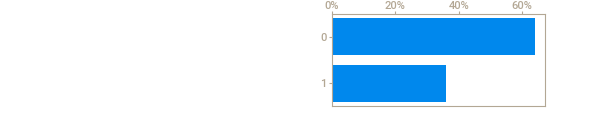
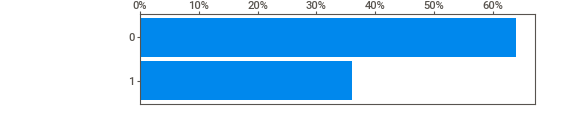
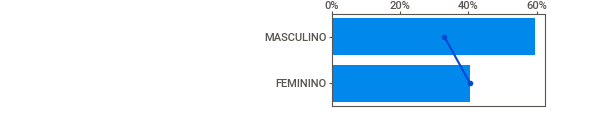
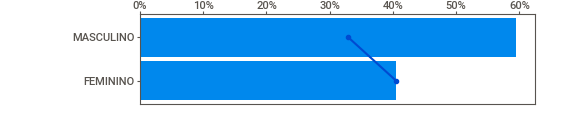
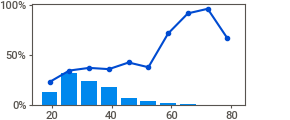
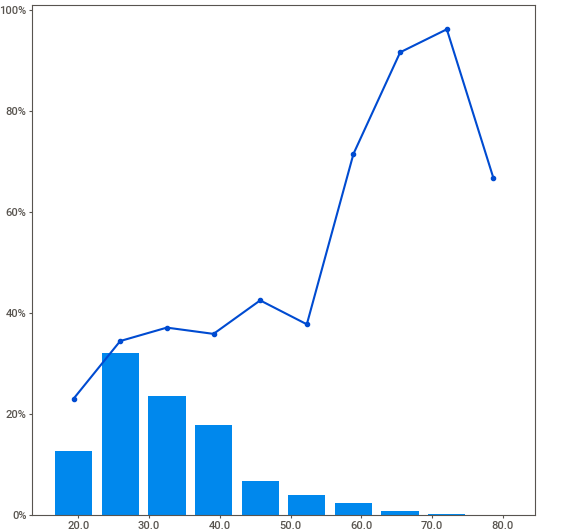
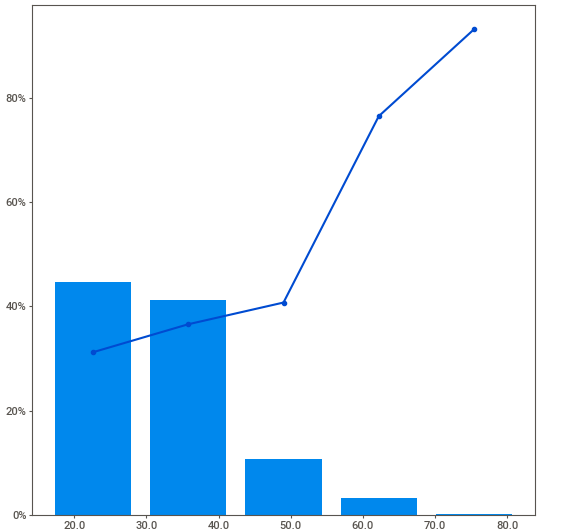
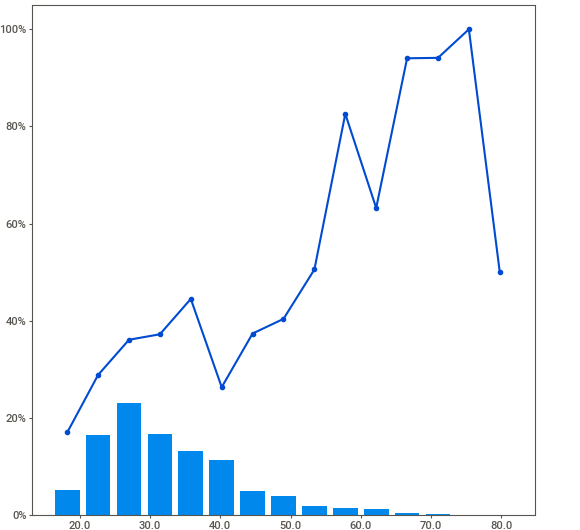
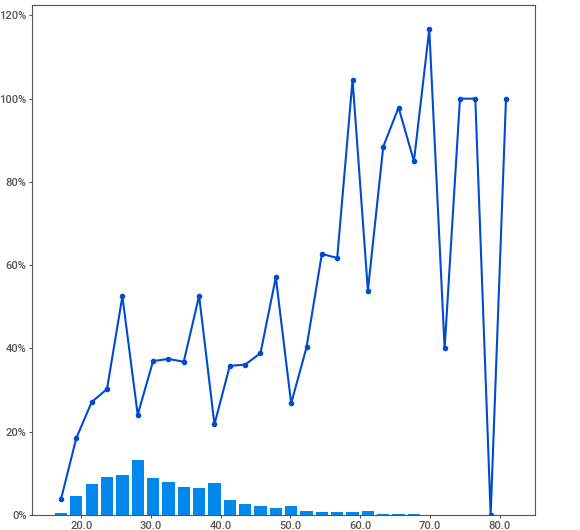
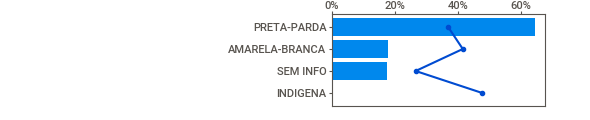
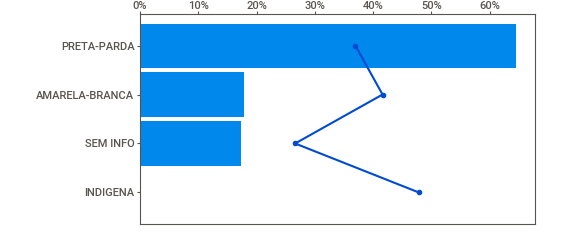
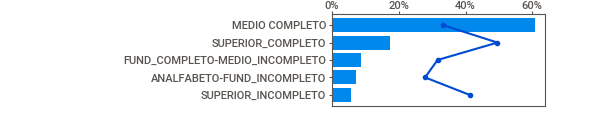
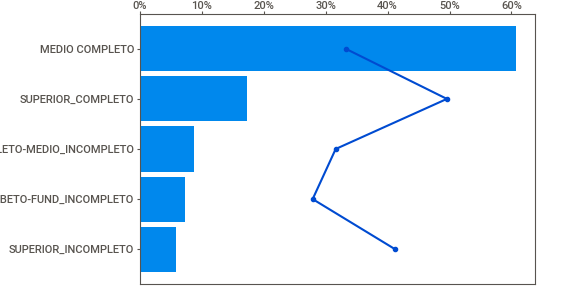
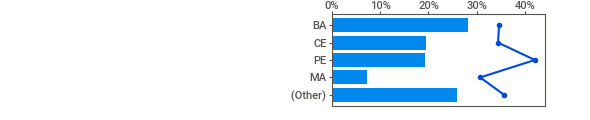
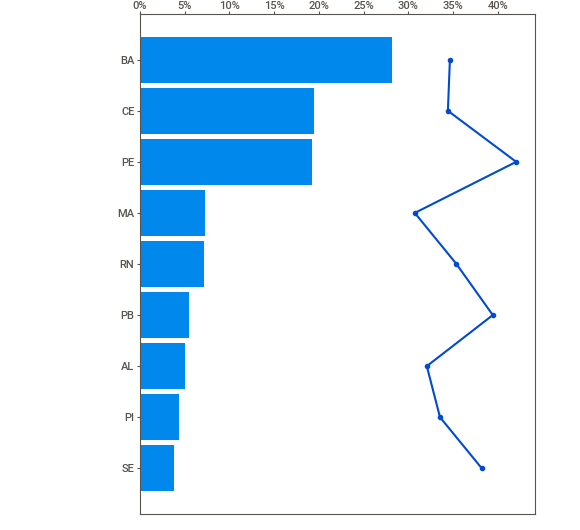
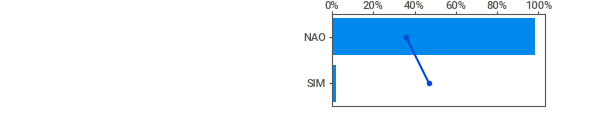
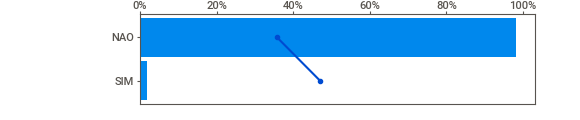
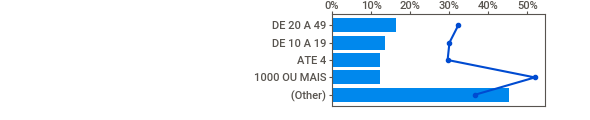
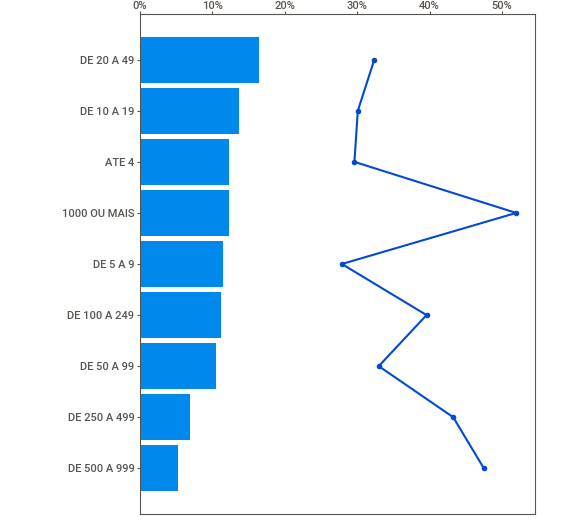
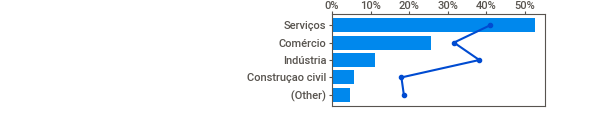
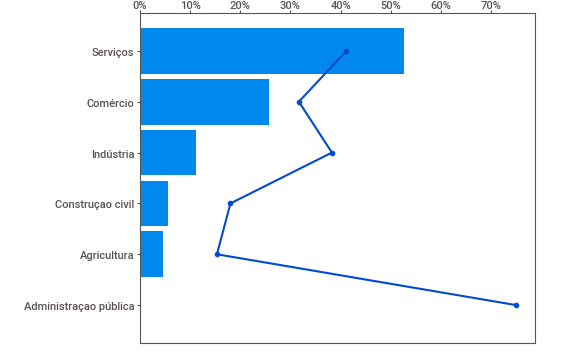
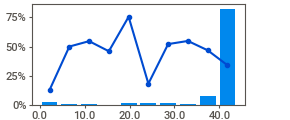
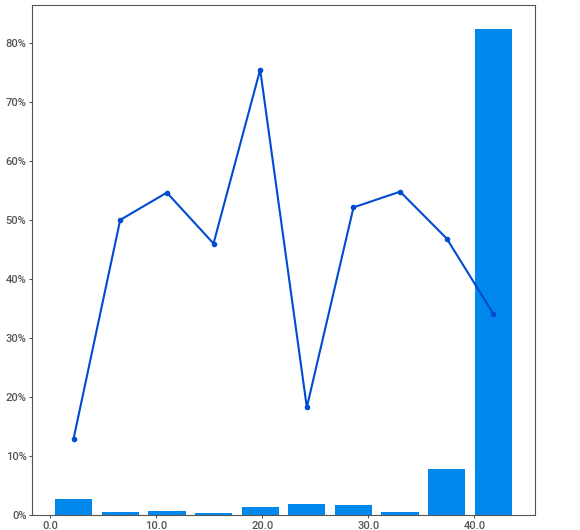
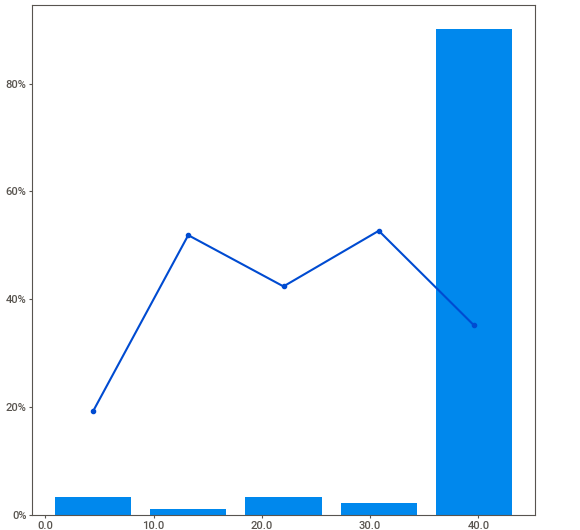
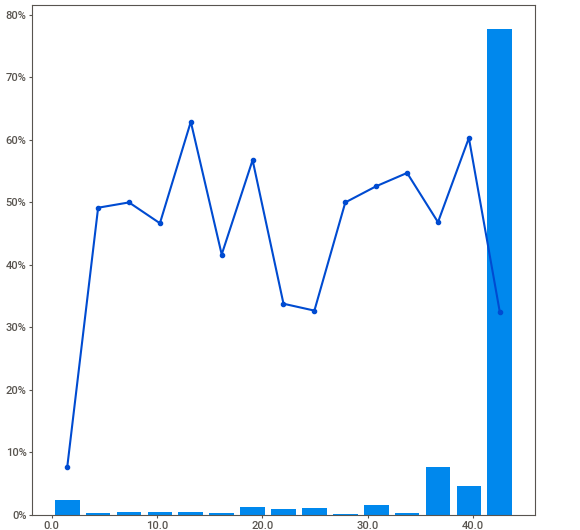
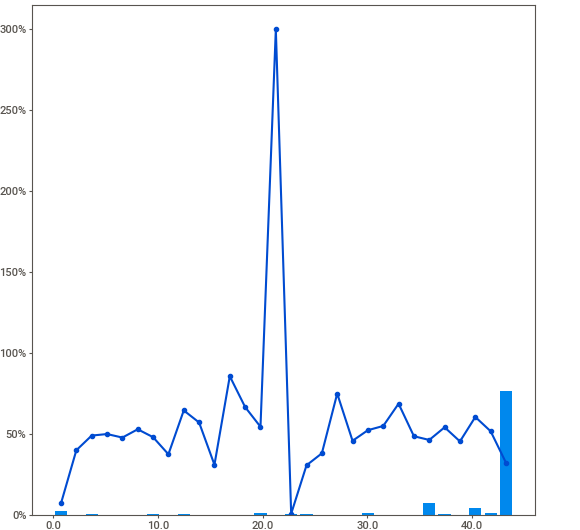
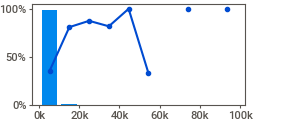
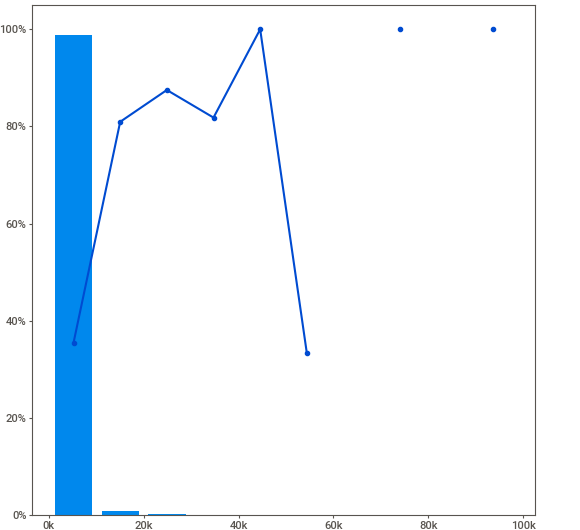
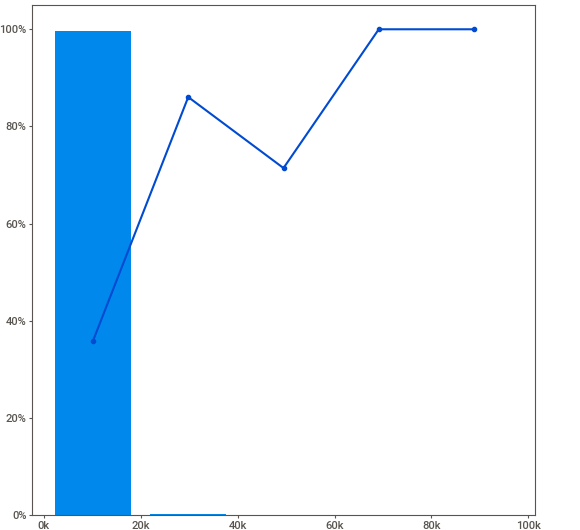
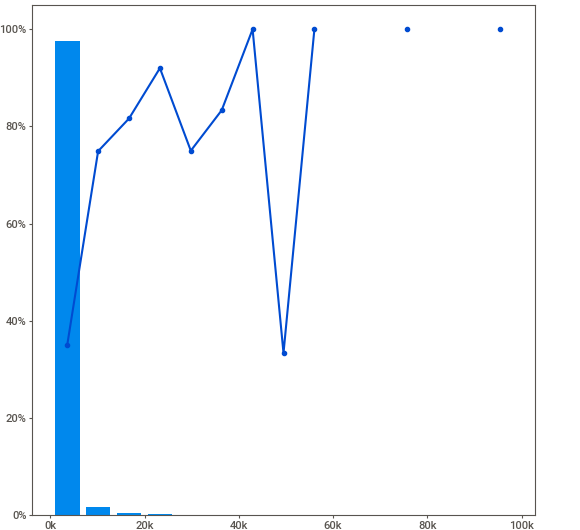
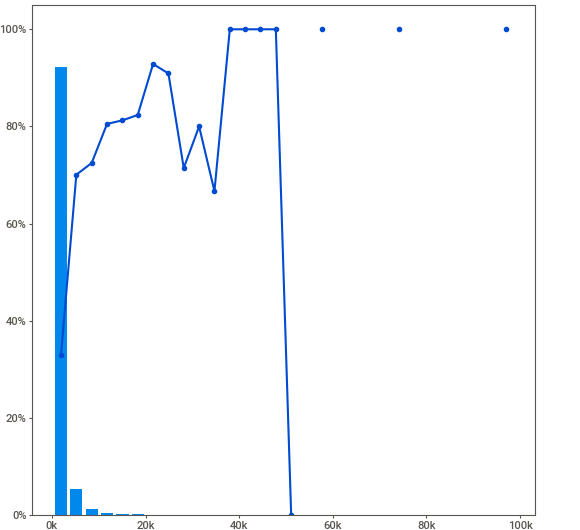
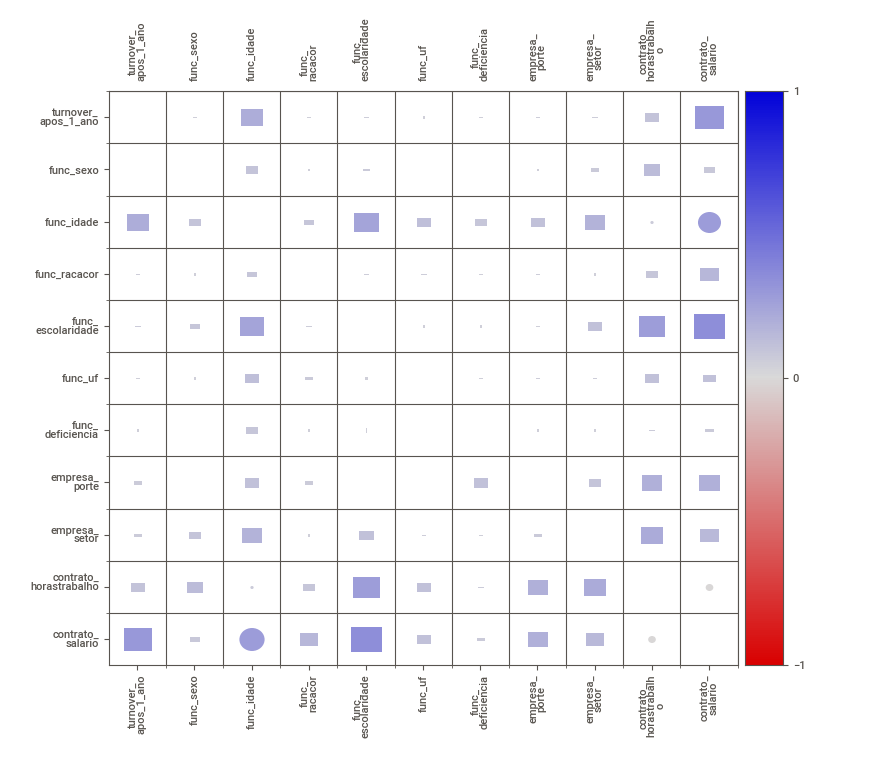
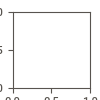

In [ ]:
df_train.turnover_apos_1_ano = df_train.turnover_apos_1_ano.map({'NAO': 0, 'SIM': 1})

eda = sv.analyze(source = df_train, 
                target_feat = 'turnover_apos_1_ano')
eda.show_notebook()

                                             |          | [  0%]   00:00 -> (? left)


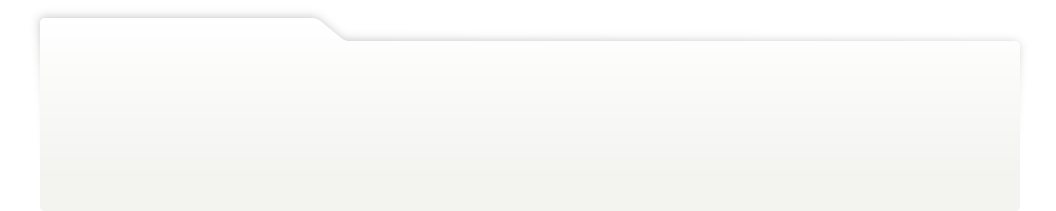
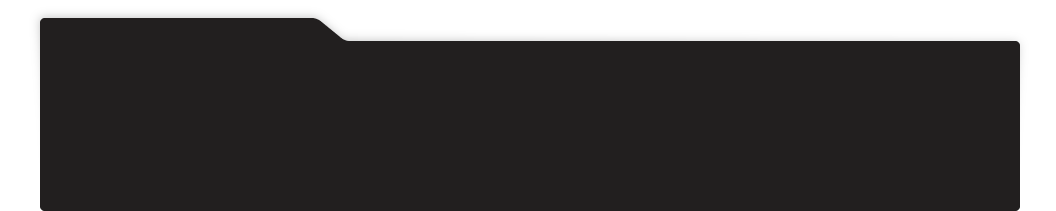
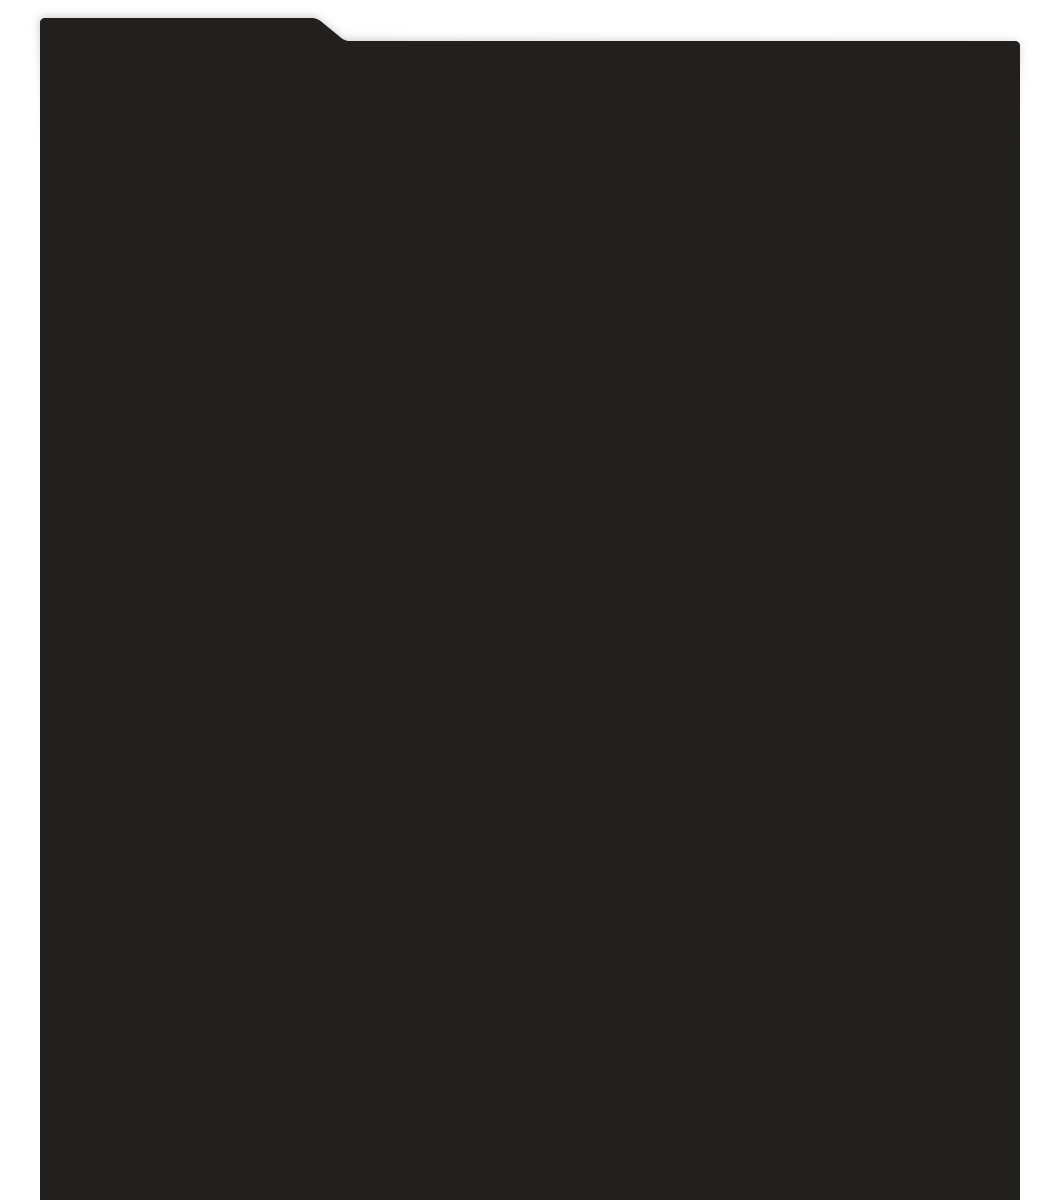
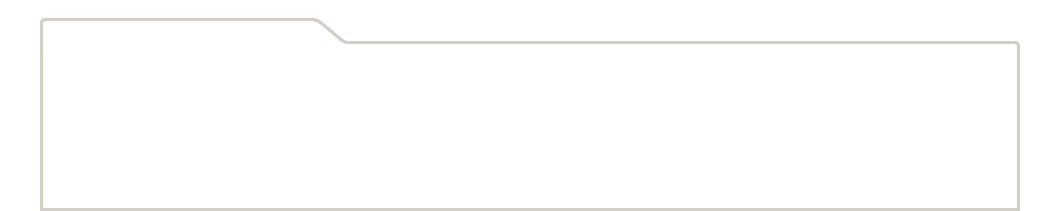
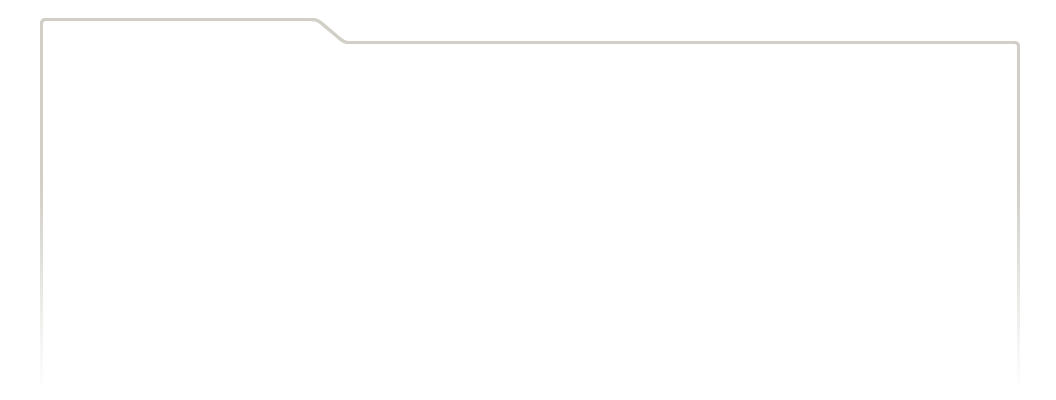
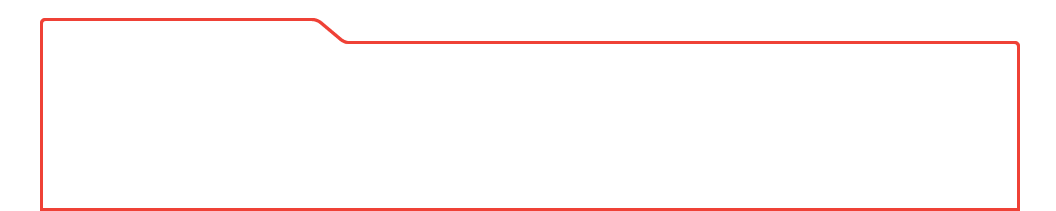
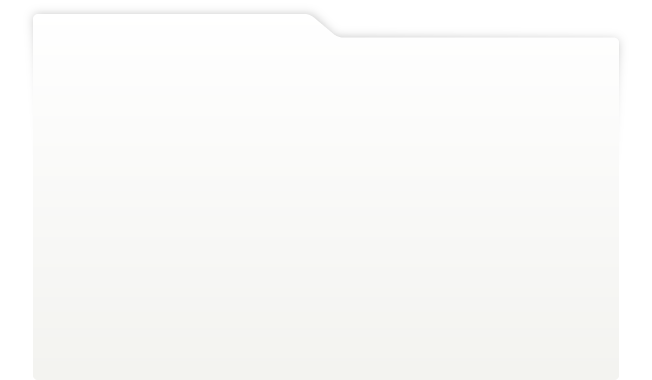
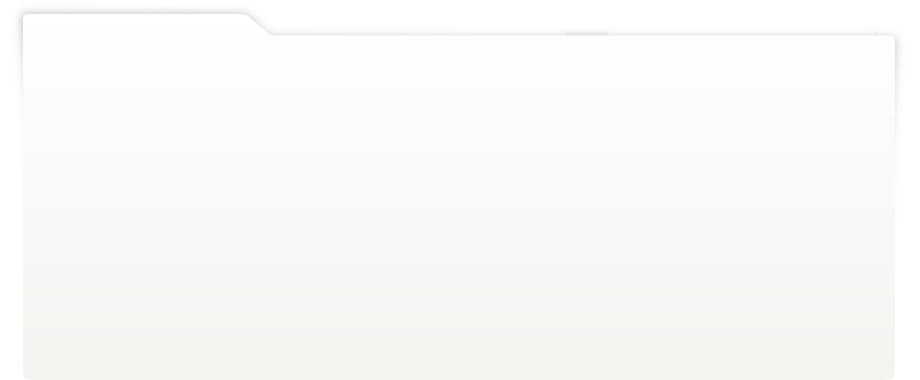
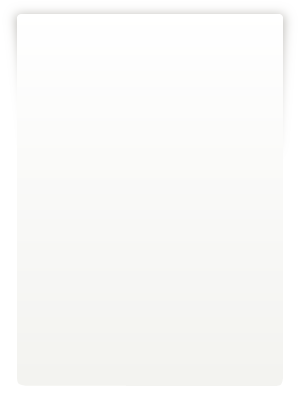
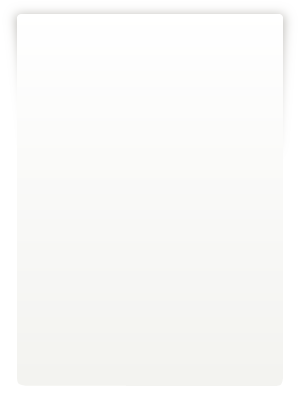
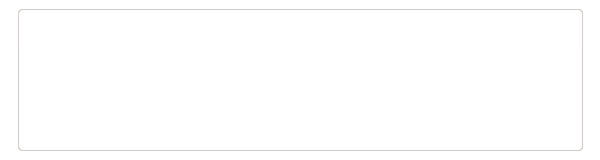
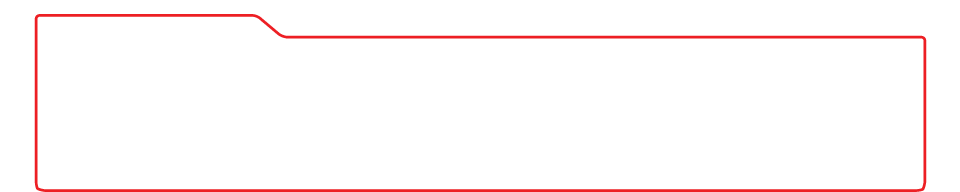
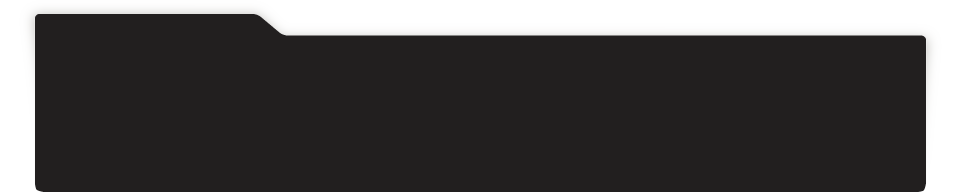
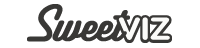
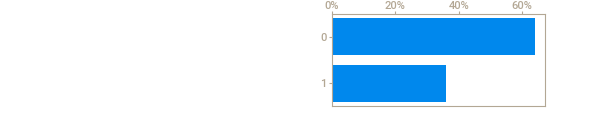
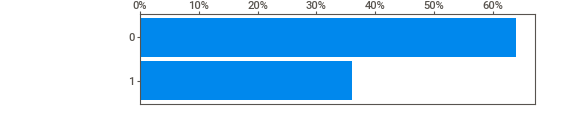
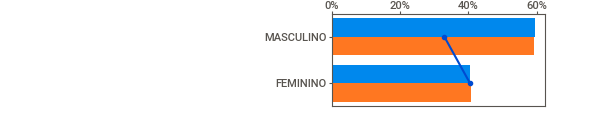
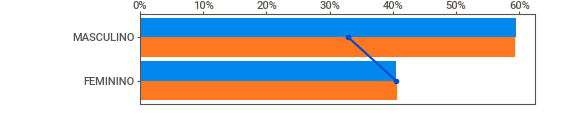
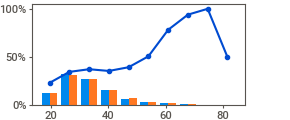
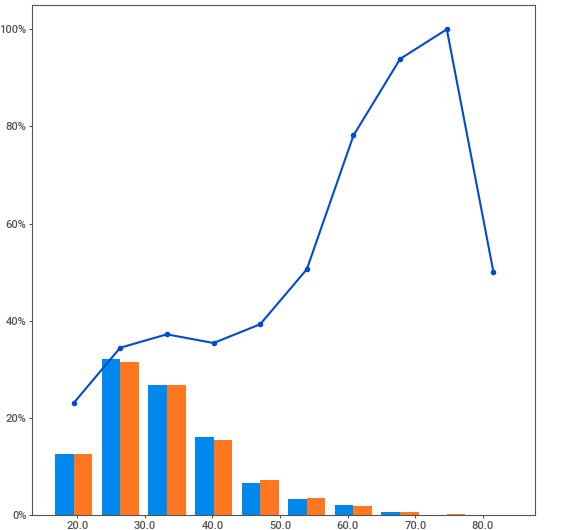
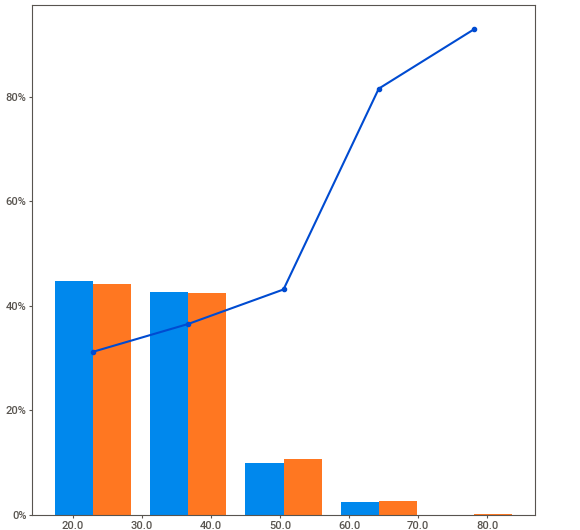
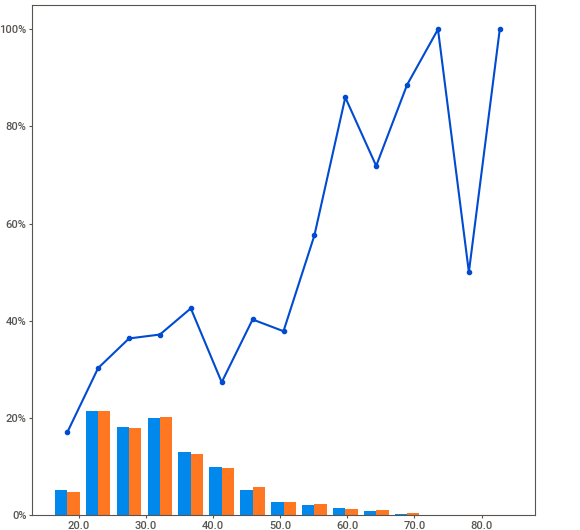
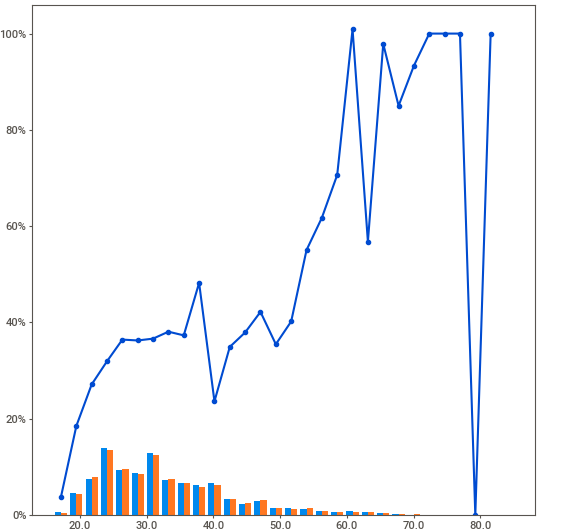
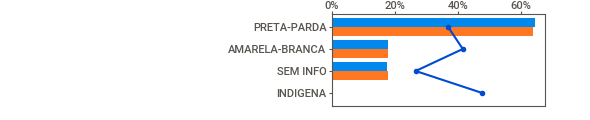
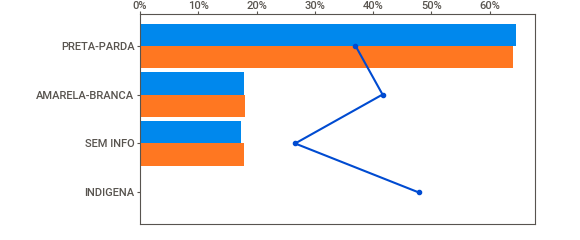
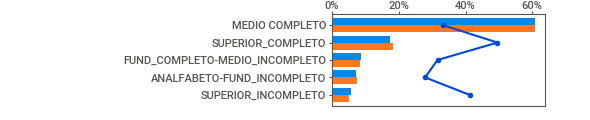
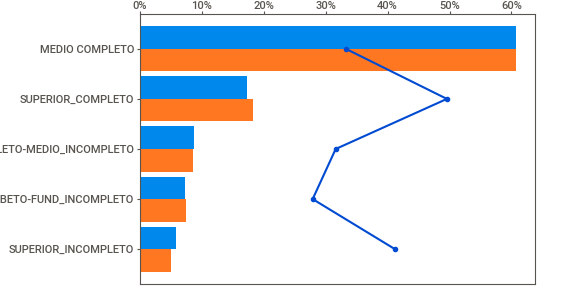
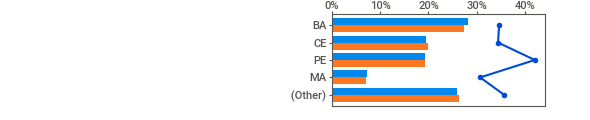
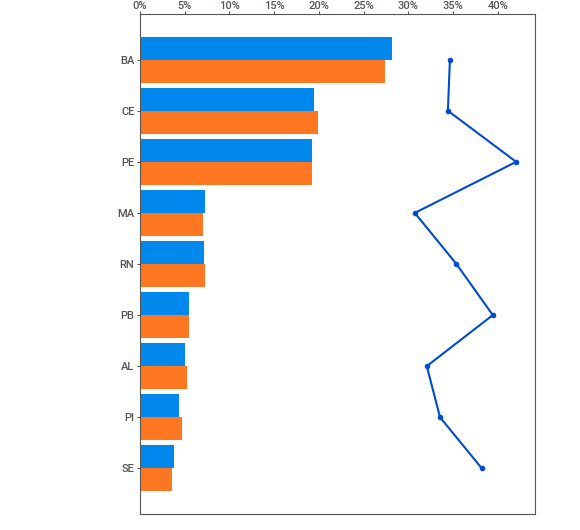
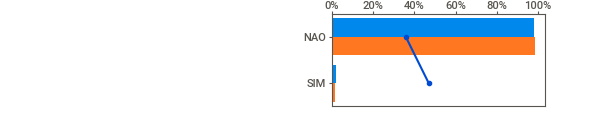
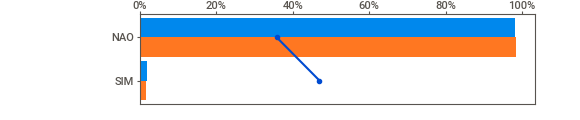
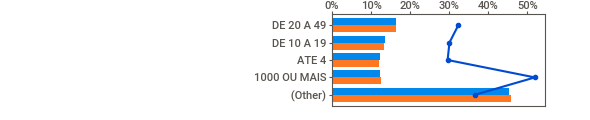
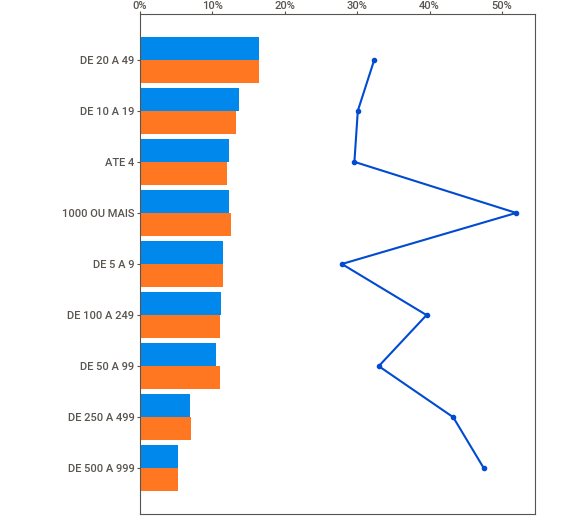
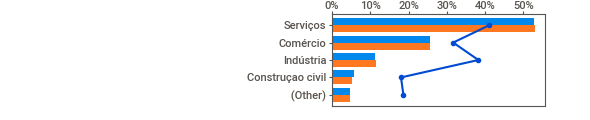
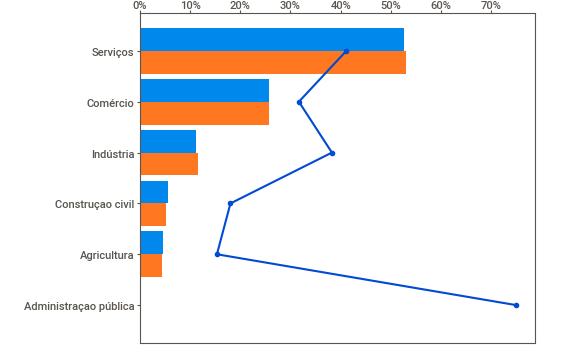
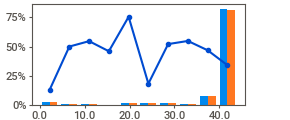
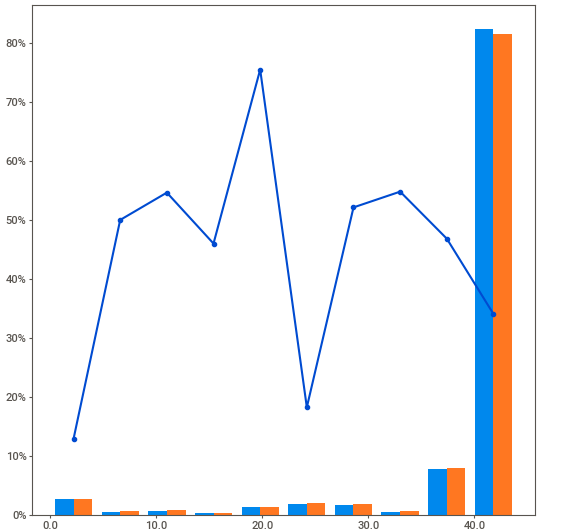
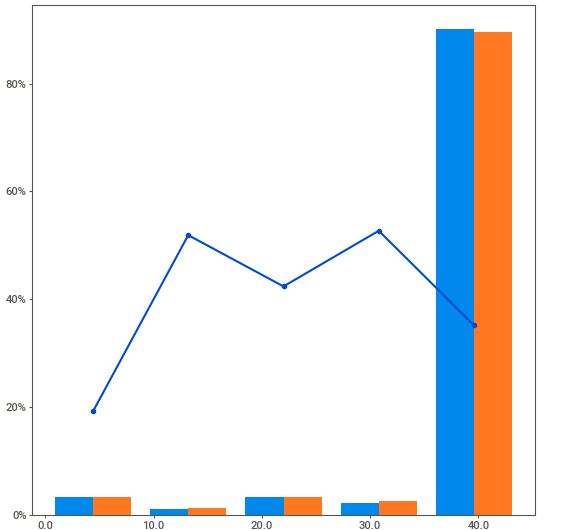
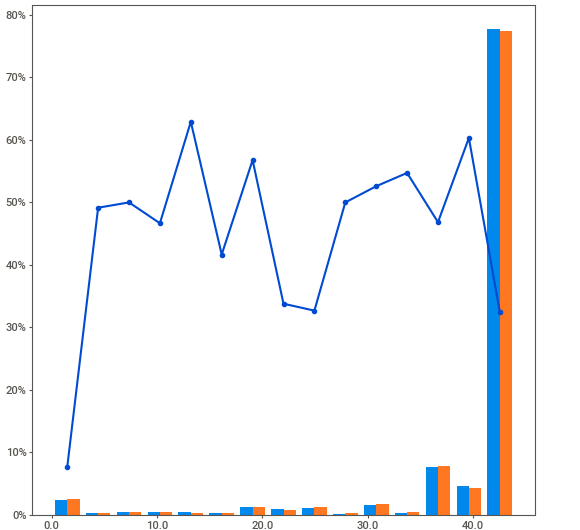
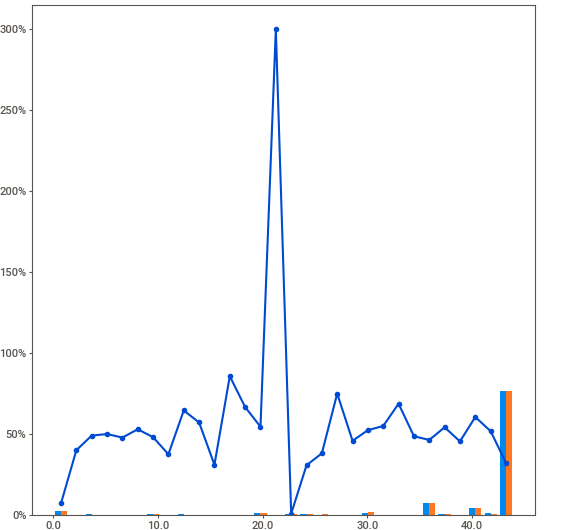
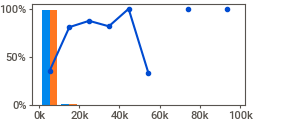
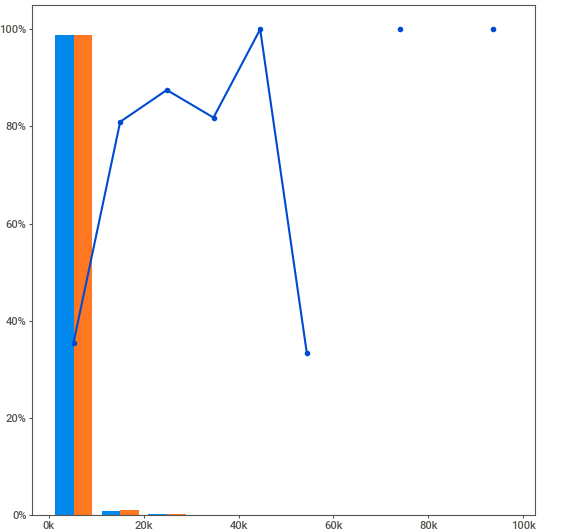
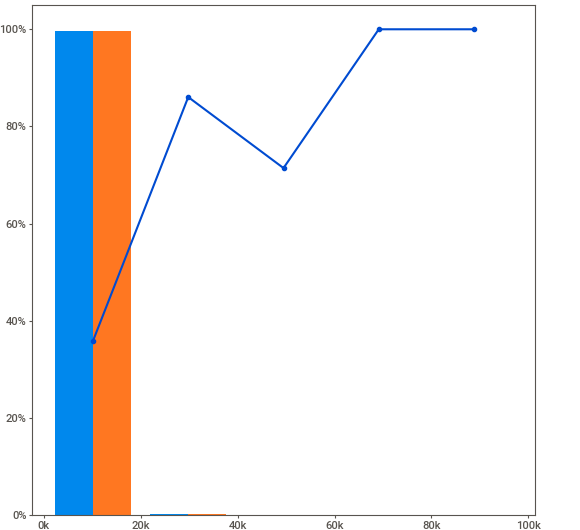
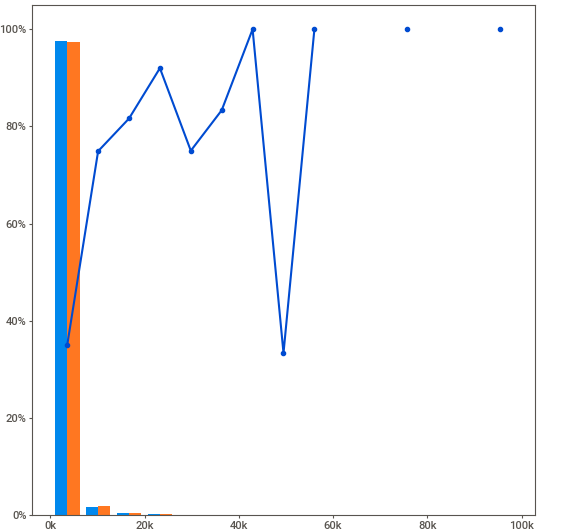
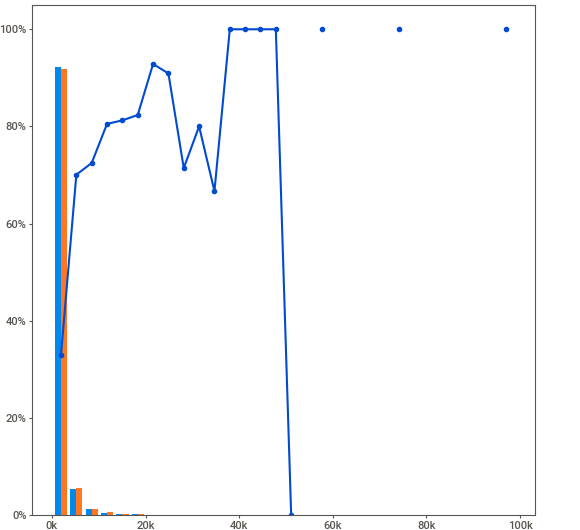
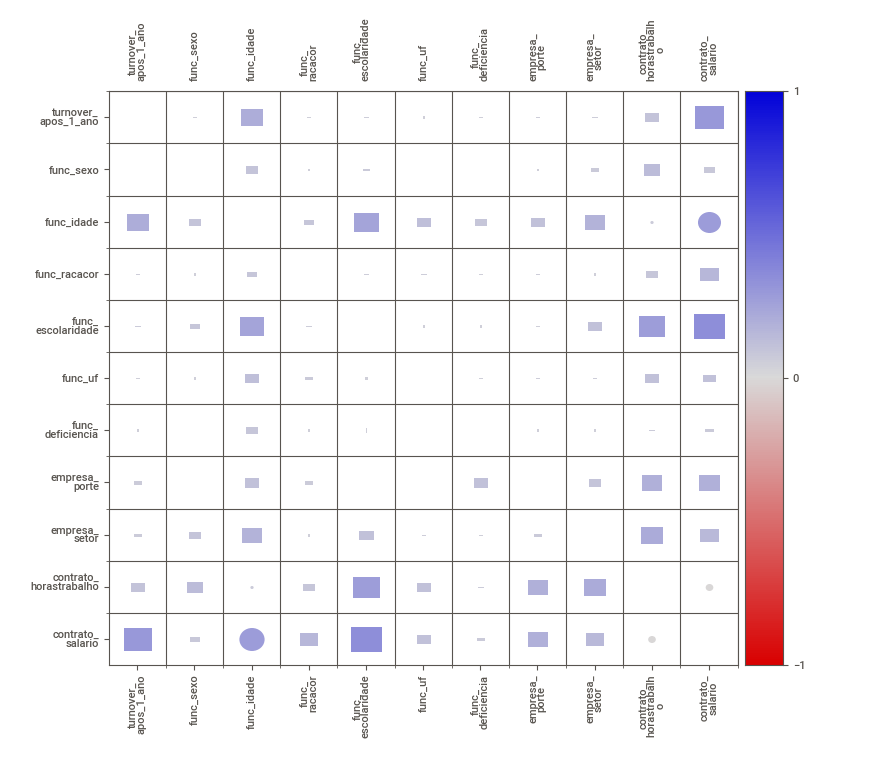
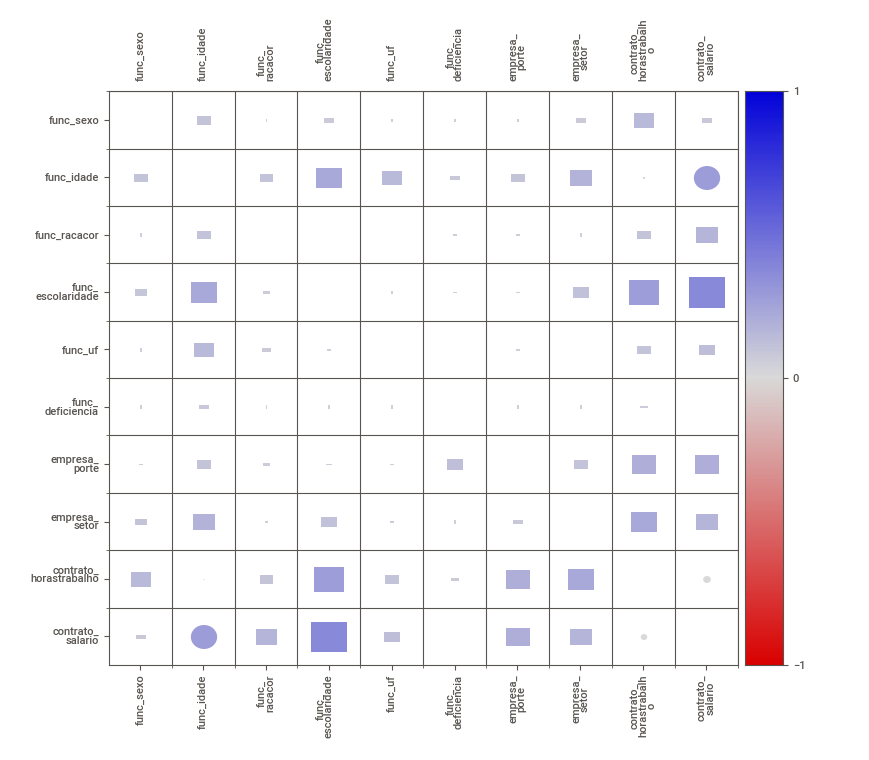

In [ ]:
comparison_report = sv.compare([df_train,'Train'], [df_test,'Test'], target_feat='turnover_apos_1_ano')
comparison_report.show_notebook()

## Exploring outliers

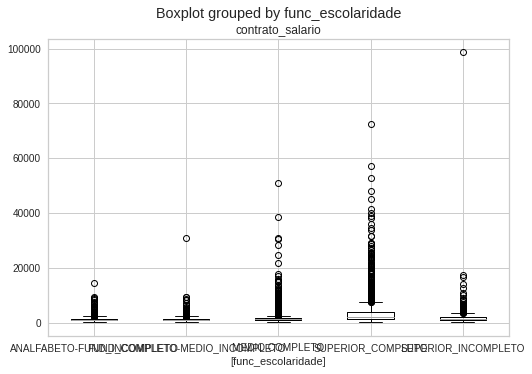

In [ ]:
df_train.boxplot(column=['contrato_salario'], by=['func_escolaridade']) 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


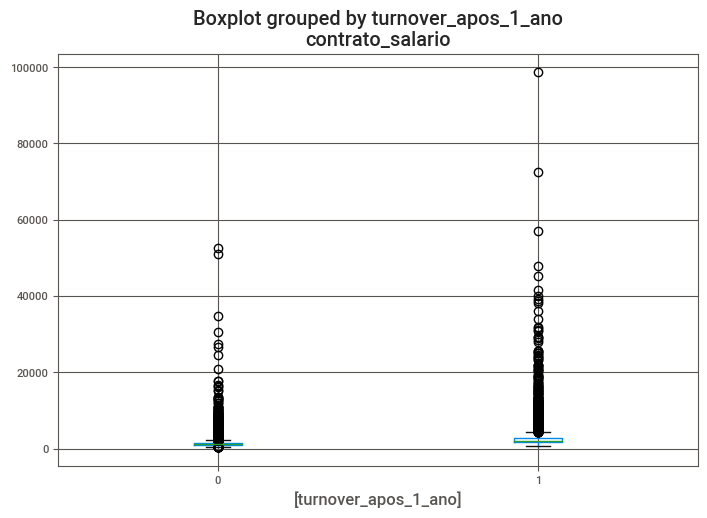

In [ ]:
df_train.boxplot(column=['contrato_salario'], by=['turnover_apos_1_ano']) 

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


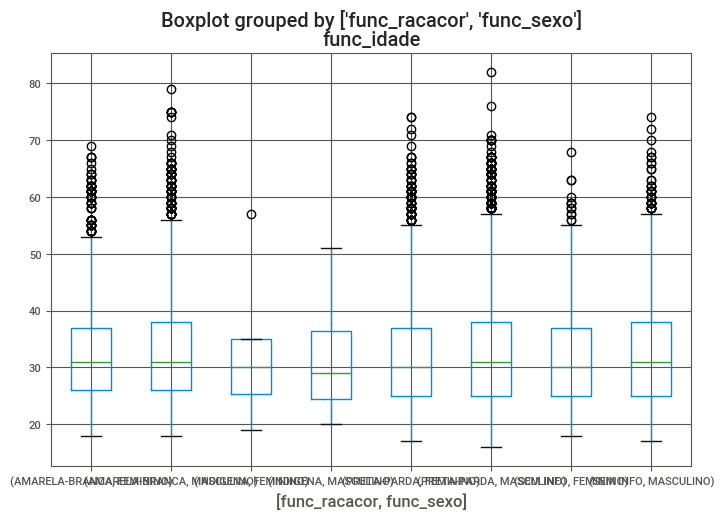

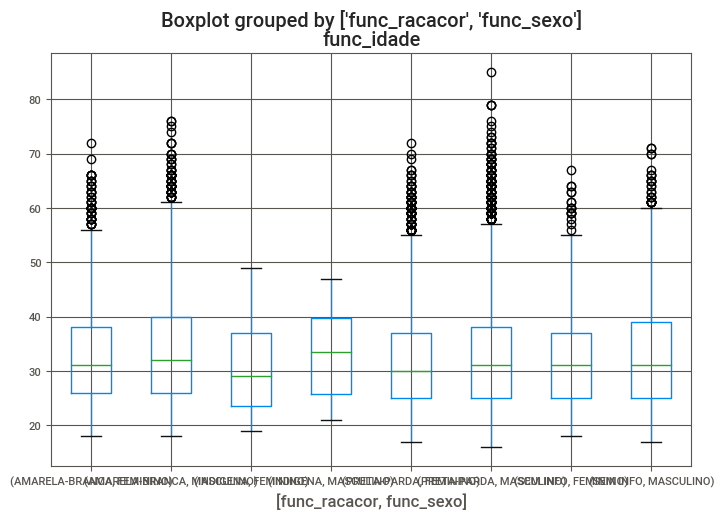

In [ ]:
boxplot = df_train.boxplot(column=['func_idade'], by=['func_racacor', 'func_sexo']) #, 'Col2', 'Col3'])#() #(by='turnover_apos_1_ano')
boxplot2 = df_test.boxplot(column=['func_idade'], by=['func_racacor', 'func_sexo']) #, 'Col2', 'Col3'])#() #(by='turnover_apos_1_ano')

---
# **PyCaret - running multiple configurations**


Em função dos *insights* para tratar os dados, crei uma função genérica para rodas diversas configurações. Essas configurações ficam numa lista com os passos as serem executados. É como se fosse um *pipeline* para chamar o Pycaret iterativamente.

A cada rodada é executada uma determinada configuração no setup do Pycaret e, na sequência, o compare_models faz uma primeira avaliação das métricas dos modelos de ML.

Todos os resultados são armazenados para serem analisados em um passo posterior.

## Setting configurations to be tested no PyCaret 

In [16]:
# features to be used by the model
feat_df_01 = ['turnover_apos_1_ano', 
              'contrato_salario', 'func_idade', 'contrato_horastrabalho', 
              'empresa_setor', 'empresa_porte', 'func_escolaridade']

# ordered categorical features
ordfeat_empresa_porte = ['ATE 4', 'DE 5 A 9', 'DE 10 A 19', 'DE 20 A 49', 'DE 50 A 99', 'DE 100 A 249', 'DE 250 A 499', 'DE 500 A 999', '1000 OU MAIS']
ordfeat_func_escolaridade = ['ANALFABETO-FUND_INCOMPLETO', 'FUND_COMPLETO-MEDIO_INCOMPLETO', 'MEDIO COMPLETO', 'SUPERIOR_INCOMPLETO', 'SUPERIOR_COMPLETO']

# global quantiles values
df_train, _ = dataset_refresh()
top_contrato_salario = df_train['contrato_salario'].quantile(0.975)
top_func_idade = df_train['func_idade'].quantile(0.975)



In [17]:
# Dataset transformation

def transf_nochange(df):
    print("Dataset transformation: nochange")
    return df

def transf_target_SIM_NAO(df):
    print("Dataset transformation: target_SIM_NAO")
    df.turnover_apos_1_ano = df.turnover_apos_1_ano.map({'NAO': 1, 'SIM': 0})
    return df

def transf_feat_df_01(df):
    print("Dataset transformation: feat_df_01")
    df = df[feat_df_01]
    return df

def transf_salario_quantile(df):
    print("Dataset transformation: salario_quantile")
    df['contrato_salario'] = df['contrato_salario'].apply (lambda x: top_contrato_salario if x > top_contrato_salario else x)
    return df

def transf_idade_quantile(df):
    print("Dataset transformation: idade_quantile")
    df['func_idade'] = df['func_idade'].apply (lambda x: top_func_idade if x > top_func_idade else x)    
    return df

def transf_RandomUnderSampler(df):
    print("Dataset transformation: RandomUnderSampler")
    treinoX = df.drop(['turnover_apos_1_ano'], axis = 1) 
    treinoy = df['turnover_apos_1_ano']

    rus = RandomUnderSampler()
    treinoXrus, treinoyrus = rus.fit_resample(treinoX, treinoy)
    treinoXrus_all = treinoXrus
    treinoXrus_all['turnover_apos_1_ano'] = treinoyrus
    return treinoXrus_all

def transf_RandomOverSampler(df):
    print("Dataset transformation: RandomOverSampler")
    treinoX = df.drop(['turnover_apos_1_ano'], axis = 1) 
    treinoy = df['turnover_apos_1_ano']

    over= RandomOverSampler(sampling_strategy='minority')
    treinoXover, treinoyover = over.fit_resample(treinoX, treinoy)
    treinoXover_all = treinoXover
    treinoXover_all['turnover_apos_1_ano'] = treinoyover
    return treinoXover_all


In [18]:
# Building all configurations (dataframe transformation and Pycaret parameters) do be evaluated

# Sample
# try_data_all = [
#    {'model_id': integer,
#     'data':  list of dataset transformation or single dataset transformation,
#     'setup':list of tuples of PyCaret parameters
#           Sample: ('silent', True), ('normalize',  True), ('combine_rare_levels',  True) 
#     },
# ]


try_data_all = [
    {'model_id': 1,
     'data':  transf_nochange,
     'setup':[('silent', True), ('session_id', 5624), 
			('normalize',  True), ('combine_rare_levels',  True), 
			('ignore_low_variance', True), ('fix_imbalance', True), ('remove_outliers', True), 
			]
    },
    {'model_id': 2,
     'data':  transf_nochange,
     'setup':[('silent', True), ('session_id', 123),  
			('normalize',  True), ('combine_rare_levels',  True), ('remove_multicollinearity', True), 
			('ignore_low_variance', True), ('fix_imbalance', True), ('remove_outliers', True), ('feature_selection', True),
			]
    },

    {'model_id': 3,
    'data':  transf_target_SIM_NAO,
     'setup':[('silent', True), ('session_id', 123),  
			('normalize',  True), ('combine_rare_levels',  True), ('remove_multicollinearity', True), 
			('ignore_low_variance', True), ('fix_imbalance', True), ('remove_outliers', True), ('feature_selection', True),
			]
    },            
    {'model_id': 4,
     'data':  [transf_feat_df_01, transf_salario_quantile],  
     'setup':[('silent', True), ('session_id', 123),  
			('normalize',  True), ('combine_rare_levels',  True), ('remove_multicollinearity', True), 
			('ignore_low_variance', True), ('fix_imbalance', True), ('remove_outliers', True), ('feature_selection', True),
			]
    },
    {'model_id': 5,
     'data':  [transf_feat_df_01, transf_idade_quantile],
     'setup':[('silent', True), ('session_id', 123),  
			('normalize',  True), ('combine_rare_levels',  True), ('remove_multicollinearity', True), 
			('ignore_low_variance', True), ('fix_imbalance', True), ('remove_outliers', True), 
			('feature_selection', True), 
			]
    },
    {'model_id': 6,
     'data':  [transf_feat_df_01, transf_salario_quantile, transf_idade_quantile],
     'setup':[('silent', True), ('session_id', 123),  
			('normalize',  True), ('combine_rare_levels',  True), ('remove_multicollinearity', True), 
			('ignore_low_variance', True), ('fix_imbalance', True), ('remove_outliers', True), 
			('feature_selection', True), 
			]
    },    
    {'model_id': 7,
     'data':  transf_RandomUnderSampler,
     'setup':[('silent', True), ('session_id', 123),  
			('normalize',  True), ('combine_rare_levels',  True), ('remove_multicollinearity', True), 
			('ignore_low_variance', True), ('fix_imbalance', True), ('remove_outliers', True), ('feature_selection', True), 
			]
    },    
    {'model_id': 8,
     'data':  transf_RandomOverSampler,
     'setup':[('silent', True), ('session_id', 123),  
			('normalize',  True), ('combine_rare_levels',  True), ('remove_multicollinearity', True), 
			('ignore_low_variance', True), ('fix_imbalance', True), ('remove_outliers', True), ('feature_selection', True), 
			]
    },
    {'model_id': 9,
     'data':  transf_RandomOverSampler,
     'setup':[('silent', True), ('session_id', 123),  
			('normalize',  True), ('combine_rare_levels',  True), ('remove_multicollinearity', True), 
			('ignore_low_variance', True), ('fix_imbalance', True), ('remove_outliers', True), 
			]
    },
    {'model_id': 10,
     'data':  [transf_feat_df_01, transf_RandomOverSampler],
     'setup':[('silent', True), ('session_id', 123),  
			('normalize',  True), ('combine_rare_levels',  True), ('remove_multicollinearity', True), 
			('ignore_low_variance', True), ('fix_imbalance', True), ('remove_outliers', True), ('feature_selection', True), 
			]
    },
    {'model_id': 11,
     'data':  transf_RandomOverSampler,
     'setup':[('silent', True), ('session_id', 123),  
			('normalize',  True), ('combine_rare_levels',  True), ('remove_multicollinearity', True), 
			('ignore_low_variance', True), ('fix_imbalance', False), ('remove_outliers', False), ('feature_selection', True), 
			]
    },
    # Sub-09    
    {'model_id': 12,
     'data':  transf_RandomOverSampler,
     'setup':[('silent', True), ('session_id', 123),  
			('normalize',  True), ('combine_rare_levels',  True), ('remove_multicollinearity', True), 
			('ignore_low_variance', True), ('fix_imbalance', True), ('remove_outliers', True), 
			('feature_selection', True), 
			('ordinal_features',  {"empresa_porte" : ordfeat_empresa_porte}), 
			]
    },
    {'model_id': 13,
     'data':  transf_RandomOverSampler,
     'setup':[('silent', True), ('session_id', 123),  
			('normalize',  False), ('combine_rare_levels',  False), ('remove_multicollinearity', False), 
			('ignore_low_variance', False), ('fix_imbalance', False), ('remove_outliers', False), 
			('feature_selection', False), 
			('ordinal_features',  {"empresa_porte" : ordfeat_empresa_porte}),
			]
    },
    {'model_id': 14,
     'data':  transf_RandomOverSampler,
     'setup':[('silent', True), ('session_id', 123),  
			('normalize',  False), ('combine_rare_levels',  False), ('remove_multicollinearity', False), 
			('ignore_low_variance', False), ('fix_imbalance', False), ('remove_outliers', False), 
			('feature_selection', True), 
			('ordinal_features',  {"empresa_porte" : ordfeat_empresa_porte}), 
			]
    },
    {'model_id': 15,
     'data':  transf_RandomOverSampler,
     'setup':[('silent', True), ('session_id', 123),  
			('remove_outliers', True), ('feature_selection', True), 
			('ordinal_features',  {"empresa_porte" : ordfeat_empresa_porte}), 
			]
    },
    {'model_id': 16,
     'data':  transf_RandomOverSampler,
     'setup':[('silent', True), ('session_id', 123),  
			('ignore_low_variance', True), ('remove_outliers', True), ('feature_selection', True), 
			('ordinal_features',  {"empresa_porte" : ordfeat_empresa_porte}), 
			]
    },
    {'model_id': 17,
     'data':  transf_RandomOverSampler,
     'setup':[('silent', True), ('session_id', 123),  
			 ('remove_multicollinearity', True), ('ignore_low_variance', True), ('fix_imbalance', False), 
             ('remove_outliers', True), ('feature_selection', True), 
 			 ('ordinal_features',  {"empresa_porte" : ordfeat_empresa_porte}), 
			]
    },
    {'model_id': 18,
     'data':  transf_RandomOverSampler,
     'setup':[('silent', True), ('session_id', 123),  
			('normalize',  True), ('combine_rare_levels',  False), ('remove_multicollinearity', True), 
			('ignore_low_variance', True), ('fix_imbalance', False), ('remove_outliers', True), 
			('feature_selection', True), 
			('ordinal_features',  {"empresa_porte" : ordfeat_empresa_porte}), 
			]
    },
    # ---------------------------------
    {'model_id': 19,
    'data':  transf_RandomOverSampler,
     'setup':[('silent', True), ('session_id', 123),  
			('normalize',  True), ('combine_rare_levels',  True), ('remove_multicollinearity', True), 
			('ignore_low_variance', True), ('fix_imbalance', True), ('remove_outliers', True), 
			('feature_selection', True), 
			('ordinal_features',  {"empresa_porte" : ordfeat_empresa_porte,"func_escolaridade" : ordfeat_func_escolaridade}),
			]
    },
    {'model_id': 20,
     'data':  transf_RandomOverSampler,
     'setup':[('silent', True), ('session_id', 123),  
			('normalize',  True), ('combine_rare_levels',  True), ('remove_multicollinearity', True), 
			('ignore_low_variance', True), ('fix_imbalance', True), ('remove_outliers', True), 
			('feature_selection', True), 
			('ordinal_features',  {"empresa_porte" : ordfeat_empresa_porte,"func_escolaridade" : ordfeat_func_escolaridade}), 
			]
    },

    # ---- like 15 ----
    {'model_id': 21,
     'data':  [transf_RandomOverSampler, transf_salario_quantile],
     'setup':[('silent', True), ('session_id', 123),  
			('remove_outliers', True), ('feature_selection', True), 
			('ordinal_features',  {"empresa_porte" : ordfeat_empresa_porte}), 
			]
    },
    {'model_id': 22,
     'data':  [transf_RandomOverSampler, transf_idade_quantile],
     'setup':[('silent', True), ('session_id', 123),  
			('remove_outliers', True), ('feature_selection', True), 
			('ordinal_features',  {"empresa_porte" : ordfeat_empresa_porte}), 
			]
    },
    {'model_id': 23,
     'data':  [transf_RandomOverSampler, transf_salario_quantile, transf_idade_quantile],
     'setup':[('silent', True), ('session_id', 123),  
			('remove_outliers', True), ('feature_selection', True), 
			('ordinal_features',  {"empresa_porte" : ordfeat_empresa_porte}), 
			]
    },

]

## Evaluating all configurations

### Special function

In [19]:
def eval_pycaret(n_try, df, target, n_best, metric, list_models=[], runPyC=True):

    i_Model = 0
    pc_setup = 0
    bestModels = 0
    models_metrics = 0
    model_desc = ""
    model_seed = -1

    print(f"Model to run: {n_try}")

    # findind the entry on list of all configs
    i_try_data_all_idx = -1
    for i in range(len(try_data_all)):
        if try_data_all[i]['model_id'] == n_try:
            i_try_data_all_idx = i
            break
        
    if i_try_data_all_idx < 0:
        # entry not found!
        print(f"Model not found")
        return pc_setup, bestModels, models_metrics, model_seed, model_desc 
    else:
        # found!
        i_Model = i_try_data_all_idx

    # running tranformation on dataset
    transf_func = try_data_all[i_Model]['data']
    if type(transf_func) != type([]):
        df = transf_func(df)
    else:
        # list
        for func_i in transf_func:
            #df_train = func_i(df_train)    
            df = func_i(df)    


    # preparing data for eval calling
    gen_fName = 'setup'
    gen_args = 0

    # preparing arguments for setup function (PyCaret)
    gen_args = ''
    for i in try_data_all[i_Model]['setup']:
        gen_args = gen_args + i[0] + '=' + str(i[1]) + ', '

    # defining description of the configuration applyed
    model_desc = 'Params: ' + gen_args +  '; Transf: ' + str(try_data_all[i_Model]['data'])

    # finalizing the argument for set setup function (PyCaret)
    gen_args = 'data=df, target=target, ' + gen_args

    # if test mode, do not continue
    if runPyC == False:
        return pc_setup, bestModels, models_metrics, model_seed, model_desc 

    print(f'Model: {n_try} (idx={i_Model}) => {gen_fName}({gen_args})')
    print(f'Desc: {model_desc}')
    #input("press any key")

    # calling setup function (PyCaret)
    #if type(gen_args) != type(0):
    pc_setup = eval('%s(%s)'%(gen_fName, gen_args))

    # Did setup run?
    if type(pc_setup) != type(0):
        # if no model was passed, use standard list
        if len(list_models) == 0:
            models_for_trying = ['lr', 'dt', 'rf', 'et', 'lightgbm', 'gbc', 'ada']
        else:
            models_for_trying = list_models

        n_best = len(models_for_trying) if n_best <= 0 else n_best

        print(f'Model: {n_try} (idx={i_Model}) => Getting best {min(n_best, len(models_for_trying))} of models of {models_for_trying}...')
        
        # get seed used in PyCaret model
        df_aux = get_config('experiment__')[0][1]
        model_seed = df_aux.iloc[0].Value

        bestModels = compare_models(include = models_for_trying, n_select = min(n_best, len(models_for_trying)), sort = metric)
        models_metrics = pull()

    else:
        print(f'Number of Models: {i_Model}')
        return pc_setup, bestModels, models_metrics, model_seed, i_Model

    return pc_setup, bestModels, models_metrics, model_seed, model_desc



In [20]:
# Sample
if False:
    df_train, _ = dataset_refresh()
    pc_setup, bestModels, models_metrics, model_seed, models_desc = eval_pycaret(10, df_train, target='turnover_apos_1_ano', 
                                                                                n_best=-5, list_models=['lr', 'ada'],
                                                                                metric='F1', 
                                                                                runPyC=True
                                                                                )

In [ ]:
def calc_f1(df, model, var_target, var_label, model_loaded=False):
    model_eval = 0
    if model_loaded == False:
        pred_train = predict_model(model, data = df, raw_score=True);
    else:
        # pred_train = df    
        # pred_train[var_label] = model.predict(df)
        # pred_train[var_label] = pred_train[var_label].map({0: 'NAO', 1: 'SIM'})
        pred_train = predict_model_rev(model, df, proba=True)

    if pred_train[var_target][0] in ['NAO', 'SIM']:
        pred_y = pred_train[var_target].map({'NAO':0, 'SIM':1})
        pred_label = pred_train[var_label].map({'NAO':0, 'SIM':1})
    else:
        pred_y = pred_train[var_target]
        pred_label = pred_train[var_label]


    clear_output()
    return pred_train, f1_score(pred_y, pred_label)

In [ ]:
def predict_model_rev(model, df, proba=False):
    if proba == False:
        pred = df.copy()    
        pred['Label'] = model.predict(df)
        pred['Label'] = pred['Label'].map({0: 'NAO', 1: 'SIM'})
    else:
        pred = df.copy()
        pred0 = model.predict_proba(pred)
        pred['Label'] = '?'
        pred['Score'] = 0.0
        for i in range(df.shape[0]):
            pred['Label'][i] = 'NAO' if pred0[i][0] >= 0.5 else 'SIM'
            pred['Score'][i] = pred0[i][0] if pred0[i][0] >= pred0[i][1] else pred0[i][1]

    return pred
        

## Running all config

O passo abaixo pode demorar mais de 30 minutos para ser finalizado. Então, se você rodado passo a passo, rode a célula abaixo e a seguinte também, assim o conteúdo será salvo num arquivo em formato Excel. Enquanto o código está rodando, envie um "oi" no Telegram! ;-)

Depois de executar o código, parei os trabalhos e fui para o Excel. Lá analisei os resultados procurando identificar o melhor modelo para seguir com as otimizações. 

Tentei diversas, mas o que melhor foi a configuração cujo "id" é o 12.

Se você não quer esperar pela execução dessa tabale, pode pular essa etapa e siga para a próxima, onde é feita a otimização do modelo.

In [ ]:
# initializing variables
n_models = len(try_data_all)
pc_setup, bestModels, score_df_train = [], [], []

# preparing dataframe to store the evaluation results
models_metrics = pd.DataFrame(columns=['idx', 'Desc', 'Model', 'Seed', 'F1-train', 'Accuracy', 'AUC', 'Recall', 'Prec.', 'F1', 'Kappa', 'MCC', 'TT (Sec)'])

#running all configs and store the results
for i in range(1, n_models+1):
    df_train, _ = dataset_refresh()
    pc_setup0, bestModels0, models_metrics0, model_seed, models_desc = eval_pycaret(i, 
                df_train, target='turnover_apos_1_ano', 
                n_best=10, metric='F1'
                )
    
    # getting model index
    models_metrics0['idx'] = i

    # getting model description
    models_metrics0['Desc'] = models_desc    
    
    # getting model seed
    models_metrics0['Seed'] = model_seed    

    # getting f1 score running the models in train dataset
    score_df_train0 = []
    for m in bestModels0:
        print(f"Calculating f1 for {m}")
        pred_df_train = predict_model(m, data = df_train, raw_score=True);
        if pred_df_train.turnover_apos_1_ano[0] in ['NAO', 'SIM']:
            pred_y = pred_df_train.turnover_apos_1_ano.map({'NAO':0, 'SIM':1})
            pred_label = pred_df_train.Label.map({'NAO':0, 'SIM':1})
        else:
            pred_y = pred_df_train.turnover_apos_1_ano #.map({'NAO':0, 'SIM':1})
            pred_label = pred_df_train.Label#.map({'NAO':0, 'SIM':1})
        score_df_train0.append(f1_score(pred_y, pred_label))        
    models_metrics0['F1-train'] = score_df_train0 

    # storing new set on metrics
    models_metrics = models_metrics.append(models_metrics0)


#print all evaluating data ordered by F1 metric
clear_output()
models_metrics.sort_values(by='F1', ascending = False)


,idx,Desc,Model,Seed,F1-train,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,13,"Params: silent=True, session_id=123, normalize...",Random Forest Classifier,123,0.939662,0.8743,0.9475,0.9370,0.8335,0.8822,0.7485,0.7545,1.343
rf,16,"Params: silent=True, session_id=123, ignore_lo...",Random Forest Classifier,123,0.932179,0.8738,0.9472,0.9384,0.8319,0.8819,0.7475,0.7538,1.297
rf,17,"Params: silent=True, session_id=123, remove_mu...",Random Forest Classifier,123,0.932179,0.8738,0.9472,0.9384,0.8319,0.8819,0.7475,0.7538,1.294
rf,18,"Params: silent=True, session_id=123, normalize...",Random Forest Classifier,123,0.932274,0.8734,0.9472,0.9379,0.8316,0.8815,0.7467,0.7530,1.282
rf,12,"Params: silent=True, session_id=123, normalize...",Random Forest Classifier,123,0.931096,0.8728,0.9467,0.9376,0.8309,0.8810,0.7454,0.7519,1.859
...,...,...,...,...,...,...,...,...,...,...,...,...,...
lr,1,"Params: silent=True, session_id=5624, normaliz...",Logistic Regression,5624,0.706206,0.7823,0.8367,0.7028,0.6906,0.6965,0.5269,0.5271,0.857
lr,5,"Params: silent=True, session_id=123, normalize...",Logistic Regression,123,0.699805,0.7803,0.8472,0.6895,0.7015,0.6950,0.5235,0.5239,0.268
et,2,"Params: silent=True, session_id=123, normalize...",Extra Trees Classifier,123,0.900594,0.7876,0.8595,0.6682,0.7196,0.6927,0.5308,0.5319,1.985
dt,6,"Params: silent=True, session_id=123, normalize...",Decision Tree Classifier,123,0.895891,0.7715,0.7564,0.7008,0.6786,0.6894,0.5088,0.5091,0.215


### Saving all results (Excel file)

In [ ]:
#save all results on an Excel file
df_export_file(models_metrics, 'models_metrics_.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Studying a particular case

Uma vez escohido um modelo para trabalhar, então roda-se o setup novamente para carregar os dados na memória da sessão e partimos para a otimização do modelo.

Neste notebook seguirei com o modelo #12.

In [23]:
# Run the particular case
df_train, _ = dataset_refresh()
pc_setup, bestModels, models_metrics, model_seed, models_desc = eval_pycaret(12, 
                                df_train, target='turnover_apos_1_ano', 
                                n_best=7, metric='F1'
                                )


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8724,0.9483,0.9363,0.8310,0.8805,0.7447,0.7509,1.880
lightgbm,Light Gradient Boosting Machine,0.8602,0.9243,0.9388,0.8121,0.8708,0.7202,0.7293,0.752
gbc,Gradient Boosting Classifier,0.8505,0.9142,0.9407,0.7978,0.8633,0.7007,0.7125,1.722
et,Extra Trees Classifier,0.8559,0.9414,0.8784,0.8416,0.8595,0.7118,0.7127,1.914
ada,Ada Boost Classifier,0.8376,0.8995,0.9151,0.7933,0.8498,0.6750,0.6834,0.994
dt,Decision Tree Classifier,0.8446,0.8445,0.8742,0.8264,0.8496,0.6891,0.6904,0.616
lr,Logistic Regression,0.7648,0.8348,0.7044,0.8030,0.7503,0.5297,0.5340,0.970


In [ ]:
models_desc

"Params: silent=True, session_id=123, normalize=True, combine_rare_levels=True, remove_multicollinearity=True, ignore_low_variance=True, fix_imbalance=True, remove_outliers=True, feature_selection=True, ordinal_features={'empresa_porte': ['ATE 4', 'DE 5 A 9', 'DE 10 A 19', 'DE 20 A 49', 'DE 50 A 99', 'DE 100 A 249', 'DE 250 A 499', 'DE 500 A 999', '1000 OU MAIS']}, ; Transf: <function transf_RandomOverSampler at 0x7f032f738290>"

In [ ]:
models_metrics

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8728,0.9467,0.9376,0.8309,0.8810,0.7454,0.7519,1.867
lightgbm,Light Gradient Boosting Machine,0.8628,0.9233,0.9454,0.8123,0.8738,0.7255,0.7357,0.801
gbc,Gradient Boosting Classifier,0.8523,0.9140,0.9418,0.7997,0.8649,0.7043,0.7159,1.672
et,Extra Trees Classifier,0.8548,0.9391,0.8748,0.8423,0.8582,0.7096,0.7103,1.962
ada,Ada Boost Classifier,0.8397,0.8988,0.9206,0.7933,0.8522,0.6791,0.6882,1.011
dt,Decision Tree Classifier,0.8470,0.8469,0.8755,0.8295,0.8518,0.6940,0.6952,0.649
lr,Logistic Regression,0.7643,0.8357,0.7044,0.8021,0.7499,0.5288,0.5330,1.017


In [ ]:
df_train, df_test = dataset_refresh()

model_eval = 0
_, f1_value = calc_f1(df_train, bestModels[model_eval], "turnover_apos_1_ano", "Label")
print(f'f1(df_train)={f1_value}')

f1(df_train)=0.9323000178157848


### Recovering the best model

Nesta seção eu tentei recuperar os modelos usados pela minha submissão matadora, porém não consegui colocar tudo no mesmo pacote. Deixei o código para o caso de alguém conseguir continuar o meu trabalho e reconstruir o modelo anterior.

Caso você não tenha interesse nesse trabalho, pule para a próxima seção.

In [25]:
# LGBMClassifier
bestModel_lightgbm = create_model("lightgbm", bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
                importance_type='split', learning_rate=0.4, max_depth=-1,
                min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
                n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
                random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
                silent='warn', subsample=1.0, subsample_for_bin=200000,
                subsample_freq=0)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8614,0.9283,0.9173,0.8258,0.8692,0.7227,0.7272
1,0.8716,0.9228,0.9267,0.8354,0.8787,0.7430,0.7475
2,0.8528,0.9194,0.9033,0.8213,0.8603,0.7054,0.7090
3,0.8504,0.9070,0.9251,0.8057,0.8613,0.7007,0.7086
4,0.8747,0.9324,0.9314,0.8373,0.8818,0.7493,0.7541
5,0.8528,0.9186,0.9142,0.8150,0.8618,0.7054,0.7107
6,0.8456,0.9085,0.9172,0.8030,0.8563,0.6911,0.6982
7,0.8589,0.9209,0.9109,0.8258,0.8663,0.7178,0.7216
8,0.8542,0.9175,0.9094,0.8197,0.8622,0.7084,0.7127


In [26]:
# GradientBoostingClassifier(
bestModel_gbc = create_model("gbc", ccp_alpha=0.0, criterion='friedman_mse', init=None,
                            learning_rate=0.15, loss='deviance', max_depth=7,
                            max_features=1.0, max_leaf_nodes=None,
                            min_impurity_decrease=0.02, min_impurity_split=None,
                            min_samples_leaf=5, min_samples_split=5,
                            min_weight_fraction_leaf=0.0, n_estimators=230,
                            n_iter_no_change=None, presort='deprecated',
                            random_state=123, subsample=0.85, tol=0.0001,
                            validation_fraction=0.1, # verbose=0,
                            warm_start=False)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8763,0.9410,0.9251,0.8435,0.8824,0.7524,0.7560
1,0.8716,0.9325,0.9251,0.8364,0.8785,0.7430,0.7473
2,0.8731,0.9357,0.9376,0.8313,0.8812,0.7461,0.7524
3,0.8606,0.9313,0.9298,0.8176,0.8701,0.7211,0.7280
4,0.8896,0.9447,0.9407,0.8541,0.8953,0.7791,0.7832
5,0.8567,0.9338,0.9189,0.8181,0.8655,0.7132,0.7188
6,0.8464,0.9253,0.9219,0.8016,0.8576,0.6926,0.7006
7,0.8730,0.9217,0.9344,0.8329,0.8807,0.7460,0.7516
8,0.8723,0.9406,0.9234,0.8383,0.8788,0.7444,0.7483


In [27]:
#  ExtraTreesClassifier(
bestModel_et = create_model("et", bootstrap=False, ccp_alpha=0.0,
                      class_weight='balanced_subsample', criterion='gini',
                      max_depth=6, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=123, 
                    #   verbose=0, 
                      warm_start=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8403,0.8933,0.9158,0.7965,0.8520,0.6803,0.6881
1,0.8520,0.8933,0.9392,0.8005,0.8643,0.7038,0.7147
2,0.8434,0.8872,0.9220,0.7976,0.8553,0.6866,0.6952
3,0.8324,0.8795,0.9204,0.7835,0.8465,0.6646,0.6751
4,0.8473,0.9036,0.9189,0.8046,0.8580,0.6944,0.7016
5,0.8442,0.8923,0.9329,0.7931,0.8573,0.6881,0.6992
6,0.8362,0.8757,0.9484,0.7752,0.8531,0.6722,0.6898
7,0.8480,0.8872,0.9344,0.7973,0.8604,0.6958,0.7063
8,0.8425,0.8943,0.9312,0.7915,0.8557,0.6848,0.6958


In [28]:
#  DecisionTreeClassifier(
bestModel_dt = create_model("dt", ccp_alpha=0.0, class_weight=None, criterion='gini',
                        max_depth=6, max_features=1.0, max_leaf_nodes=None,
                        min_impurity_decrease=0.0001, min_impurity_split=None,
                        min_samples_leaf=4, min_samples_split=10,
                        min_weight_fraction_leaf=0.0, presort='deprecated',
                        random_state=123, splitter='best')


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8449,0.8999,0.9392,0.7911,0.8588,0.6897,0.7022
1,0.8379,0.8917,0.9407,0.7811,0.8535,0.6755,0.6902
2,0.8457,0.8898,0.9470,0.7883,0.8604,0.6912,0.7058
3,0.8340,0.8849,0.9470,0.7732,0.8513,0.6677,0.6854
4,0.8559,0.9013,0.9438,0.8035,0.8680,0.7116,0.7228
5,0.8473,0.8921,0.9548,0.7866,0.8626,0.6943,0.7109
6,0.8284,0.8812,0.9578,0.7615,0.8484,0.6565,0.6796
7,0.8456,0.8857,0.9469,0.7880,0.8602,0.6910,0.7056
8,0.8582,0.8944,0.9641,0.7961,0.8721,0.7161,0.7327


In [29]:
#  AdaBoostClassifier(
bestModel_ada = create_model("ada", algorithm='SAMME.R', base_estimator=None, learning_rate=0.2,
                    n_estimators=230, random_state=123)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8371,0.9088,0.9048,0.7978,0.8480,0.6741,0.6803
1,0.8496,0.9076,0.9267,0.8038,0.8609,0.6991,0.7075
2,0.8348,0.8960,0.8970,0.7986,0.8450,0.6694,0.6746
3,0.8246,0.8916,0.9095,0.7784,0.8388,0.6489,0.6584
4,0.8481,0.9073,0.9142,0.8083,0.8580,0.6960,0.7021
5,0.8434,0.9049,0.9189,0.7992,0.8549,0.6866,0.6945
6,0.8252,0.8934,0.9250,0.7718,0.8415,0.6502,0.6635
7,0.8362,0.8906,0.9141,0.7916,0.8484,0.6723,0.6805
8,0.8448,0.9005,0.9250,0.7978,0.8567,0.6895,0.6985


In [30]:
bestModel_recovered = [bestModel_lightgbm, bestModel_gbc, bestModel_et, bestModel_dt, bestModel_ada]

In [ ]:
bestModel_tuned_soft = blend_models(bestModel_recovered)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8724,0.9419,0.9531,0.8210,0.8821,0.7446,0.7545
1,0.8755,0.9283,0.9656,0.8185,0.8860,0.7509,0.7634
2,0.8708,0.9302,0.9547,0.8179,0.8810,0.7415,0.7521
3,0.8559,0.9219,0.9516,0.7992,0.8688,0.7117,0.7251
4,0.8755,0.9355,0.9422,0.8317,0.8835,0.7509,0.7576
5,0.8559,0.9273,0.9298,0.8109,0.8663,0.7117,0.7195
6,0.8534,0.9217,0.9531,0.7953,0.8671,0.7067,0.7212
7,0.8589,0.9142,0.9484,0.8050,0.8709,0.7177,0.7295
8,0.8723,0.9324,0.9562,0.8193,0.8825,0.7444,0.7551


In [ ]:
bestModel_tuned_soft

VotingClassifier(estimators=[('lightgbm',
                              LGBMClassifier(bagging_fraction=0.9,
                                             bagging_freq=3,
                                             boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             feature_fraction=0.5,
                                             importance_type='split',
                                             learning_rate=0.4, max_depth=-1,
                                             min_child_samples=6,
                                             min_child_weight=0.001,
                                             min_split_gain=0.3,
                                             n_estimators=20, n_jobs=-1,
                                             num_leaves=150, objective=None,
                                             rand...
              

Se você executou os passos desta seção não execute os passos da seção "Optimizing an ensemble".

### Optimizing an ensemble

In [ ]:
# tuning all ML from the particular case
bestModels_tuned = []
bestModels_tuned_F1s = []
for i in bestModels:
    model_name = str(i)
    model_name = model_name.split(sep='(')[0]
    print(f"Analysing: {model_name}")
    bestModels_tuned.append(tune_model(i, optimize = 'F1'))

    dt_results_tuned = pull()

    print(f"Calculating f1 for {i}")
    _, model_f1_train = calc_f1(df_train, i, "turnover_apos_1_ano", "Label")

    bestModels_tuned_F1s.append([model_name, 
                                 i,
                                 dt_results_tuned.loc['Mean']['F1'], 
                                 dt_results_tuned.loc['Std']['F1'], 
                                 model_f1_train ,
                                 (dt_results_tuned.loc['Mean']['F1'] - model_f1_train)
                                ])

df_bestModels_tuned_F1s = pd.DataFrame(bestModels_tuned_F1s, columns=['Model', 'Params', 'F1', 'Std', 'F1-Train', 'F1-delta'])


In [ ]:
df_bestModels_tuned_F1s.sort_values(by='F1', ascending = False)

,Model,F1,Std,F1-Train,F1-delta,Params
2,GradientBoostingClassifier,0.8820,0.0068,0.799874,0.082126,"([DecisionTreeRegressor(ccp_alpha=0.0, criteri..."
1,LGBMClassifier,0.8693,0.0057,0.828403,0.040897,"LGBMClassifier(boosting_type='gbdt', class_wei..."
5,DecisionTreeClassifier,0.8611,0.0044,0.918807,-0.057707,"DecisionTreeClassifier(ccp_alpha=0.0, class_we..."
0,RandomForestClassifier,0.8580,0.0053,0.933762,-0.075762,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
4,AdaBoostClassifier,0.8537,0.0092,0.784492,0.069208,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w..."
3,ExtraTreesClassifier,0.8536,0.0066,0.923105,-0.069505,"(ExtraTreeClassifier(ccp_alpha=0.0, class_weig..."
6,LogisticRegression,0.7530,0.0077,0.705463,0.047537,"LogisticRegression(C=1.0, class_weight=None, d..."


In [ ]:
df_export_file(df_bestModels_tuned_F1s, 'models_tuned_metrics_Ref12.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Durante a competição concluí que modelos com F1 muito alto não tinham o mesmo desempenho na base de teste. Modelos com baixo F1 igualmente tinham desempenho ruim. Dessa forma, descartei o melhor e o pior modelo e fiz um ensemble com os demais modelos.

Meu ensemble era composto por 5 modelos de ML: LGBM, DecisionTree, RandomForest, AdaBoost e ExtraTrees.

Se você rodou todos os passos anteriores até aqui, é nesse ponto que o Pycaret gera uma resposta diferente a cada execução.

O modelo que deu origem a minha 9ª submissão, até agora foi único, e não consegui reproduzi-lo novamente.

In [44]:
# blending ML chosen from tuning process
bestModel_tuned_soft = blend_models([
                                     bestModels_tuned[1], 
                                     bestModels_tuned[2], 
                                     bestModels_tuned[3], 
                                     bestModels_tuned[4],
                                     bestModels_tuned[5]
                                     ], method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8622,0.9386,0.9407,0.8138,0.8726,0.7242,0.7332
1,0.8763,0.9263,0.9563,0.8250,0.8858,0.7524,0.7622
2,0.8653,0.9298,0.9423,0.8173,0.8754,0.7305,0.7392
3,0.8551,0.9219,0.9485,0.8000,0.8680,0.7100,0.7227
4,0.8802,0.9392,0.9485,0.8352,0.8882,0.7602,0.7674
5,0.8551,0.9281,0.9345,0.8073,0.8662,0.7101,0.7191
6,0.8480,0.9221,0.9453,0.7919,0.8618,0.6957,0.7093
7,0.8558,0.9226,0.9328,0.8089,0.8665,0.7115,0.7200
8,0.8683,0.9304,0.9516,0.8164,0.8788,0.7365,0.7469


### Checking score

In [45]:
df_train, df_test = dataset_refresh()

In [50]:
_, model_f1_train = calc_f1(df_train, bestModel_tuned_soft, "turnover_apos_1_ano", "Label")
print(f'f1(df_train)={model_f1_train}')
# f1(df_train)=0.8560824742268042

f1(df_train)=0.8546516410298592


## Saving the model

In [ ]:
model_name = 'Sub_Ref12_rev'

In [ ]:
# finalizing the model
model_final = finalize_model(model_work)
save_model(model_final, model_name)

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[],
                                       target='turnover_apos_1_ano',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None...
                                                                       class_weight=None,
                                                                       criterion='entropy',
                                                                       max_depth=6,
   

In [58]:
if False:
    model_name = 'Sub_Ref12_rev'

## Loading the model

Neste ponto você poderá carregar o modelo que eu salvei pouco antes de enviar a minha submissão matadora.

Carregue o arquivo na pasta do colab e execute os próximos passos.

In [59]:
# Loading the salved model
model_loaded = load_model(model_name)

Transformation Pipeline and Model Successfully Loaded


In [54]:
if False:
    model_loaded[23].estimators
    #help(model_loaded[23])
    # model_loaded[23].estimators_
    # model_loaded[23]

In [60]:
df_train, df_test = dataset_refresh()

In [62]:
pred_train, model_f1_train = calc_f1(df_train, model_loaded, "turnover_apos_1_ano", "Label", model_loaded=True)
print(f'f1(df_train)={model_f1_train}')

# f1(df_train)=0.8687618576260001

f1(df_train)=0.8687618576260001


Exportação do dataset de treino com os valores preditos.

Com o arquivo exportado é possível analisar quais predições foram corretas.


In [ ]:
df_export_file(pred_train, model_name + "_pred_train.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
pred_test = predict_model_rev(model_loaded, df_test, proba=True)
pred_test

,func_sexo,func_idade,func_racacor,func_escolaridade,func_uf,func_deficiencia,empresa_porte,empresa_setor,contrato_horastrabalho,contrato_salario,Label,Score
0,FEMININO,30,PRETA-PARDA,MEDIO COMPLETO,MA,NAO,ATE 4,Comércio,44,1583.19,SIM,0.731434
1,MASCULINO,21,SEM INFO,MEDIO COMPLETO,BA,NAO,DE 5 A 9,Indústria,44,979.95,NAO,0.835604
2,FEMININO,26,SEM INFO,MEDIO COMPLETO,RN,NAO,ATE 4,Comércio,44,1015.85,NAO,0.836877
3,MASCULINO,49,PRETA-PARDA,MEDIO COMPLETO,BA,NAO,DE 5 A 9,Comércio,44,1089.45,NAO,0.829939
4,FEMININO,31,SEM INFO,MEDIO COMPLETO,BA,NAO,ATE 4,Serviços,44,1281.62,NAO,0.808369
...,...,...,...,...,...,...,...,...,...,...,...,...
14995,FEMININO,30,AMARELA-BRANCA,MEDIO COMPLETO,PI,NAO,DE 50 A 99,Serviços,44,1142.91,NAO,0.821915
14996,FEMININO,24,PRETA-PARDA,MEDIO COMPLETO,BA,NAO,DE 10 A 19,Serviços,44,1385.88,SIM,0.514326
14997,FEMININO,36,SEM INFO,SUPERIOR_COMPLETO,PE,NAO,DE 20 A 49,Serviços,40,5854.13,SIM,0.689716
14998,MASCULINO,41,SEM INFO,MEDIO COMPLETO,BA,NAO,DE 10 A 19,Serviços,22,500.00,NAO,0.853599


Exportação do dataset de teste com os valores preditos.


In [ ]:
df_export_file(pred_test[['Label', 'Score']], model_name + "_pred_test.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Submission file

In [ ]:
subm = pd.DataFrame()
subm['turnover_apos_1_ano'] = pred_test.Label#.map({1: 'NAO', 0: 'SIM'})


In [ ]:
subm

,turnover_apos_1_ano
0,SIM
1,NAO
2,NAO
3,NAO
4,NAO
...,...
14995,NAO
14996,NAO
14997,SIM
14998,NAO


In [ ]:
subm.value_counts()

turnover_apos_1_ano
NAO                    7862
SIM                    7138
dtype: int64

Exportação do arquivo para submissão

In [ ]:
df_export_file(subm, model_name + '_sub.csv', typeOfFile='csv')   

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>